###Setting up our Random Number Generator

In [3]:
%%writefile random_number_gen.pyx

import numpy as np
cimport numpy as np
import scipy

cimport scipy
from cpython.mem cimport PyMem_Malloc, PyMem_Free
cdef class RandomNumberGen:
    cdef unsigned long long mod1, a1, a2, a3, mod2, b1, b2, b3, x0, x1, x2
    cdef double multiplicator
    cdef bint LHS

    def __cinit__(self):
        self.mod1 = 2**31 - 1
        self.a1 = 0
        self.a2 = 63308
        self.a3 = -183326
        self.mod2 = 2145483479
        self.b1 = 86098
        self.b2 = 0
        self.b3 = -539608
        self.x0=17  ## Define Seed Here
        self.x1=37  ## Define Seed Here
        self.x2=13337 ## Define Seed Here
        self.multiplicator=4.656612875245797e-10
        self.LHS=True

    cpdef double Scrambled_Random(self):
        cdef unsigned long long Component1, Component2, Combined, y
        Component1 = (self.x2 * self.a1 + self.x1 * self.a2 + self.x0 * self.a3) % self.mod1
        Component2 = (self.x2 * self.b1 + self.x1 * self.b2 + self.x0 * self.b3) % self.mod2
        Combined = (Component1 - Component2) % self.mod1
        if Combined < 0:
            Combined += self.mod1
        y = Combined
        y ^= (y << 17)  # Parentheses to avoid type mismatch
        y ^= (y >> 15)  # Parentheses to avoid type mismatch
        y ^= (y << 26)  # Parentheses to avoid type mismatch
        y = y % self.mod1
        self.x2, self.x1, self.x0 = y, self.x2, self.x1

        return y*self.multiplicator

    cpdef np.ndarray generate_matrix(self, int rows,int cols,LHS=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t i, j
        if LHS:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = i/rows+self.Scrambled_Random()/rows
            for j in range(cols):
                matrix[:, j] = np.random.permutation(matrix[:, j])
            return matrix
        else:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = self.Scrambled_Random()
            return matrix





        return matrix
    cpdef np.ndarray inverse_transform(self, np.ndarray input_matrix,np.ndarray CDF_matrix,np.ndarray X_vector):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((input_matrix.shape[0], input_matrix.shape[1]), dtype=np.double)
        cdef Py_ssize_t i, j
        cdef double u
        for i in range(input_matrix.shape[0]):
            for j in range(input_matrix.shape[1]):
                u = input_matrix[i, j]
                matrix[i, j] = np.interp(u, CDF_matrix, X_vector)

        return matrix
    cpdef np.ndarray generate_poisson(self,int rows,int cols,double lambda_,bint Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t  i, j
        cdef double comp=np.exp(-lambda_)
        cdef np.ndarray[np.double_t,ndim=2] Sample
        cdef double u,u2,k1,k2,comp2,Prob
        if Antithetic:
            sample=self.generate_matrix(rows//2,cols)
            for i in range(rows//2):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    u2=1-u
                    k1=0
                    k2=0

                    while u>comp2:
                        k1=k1+1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    comp2=comp
                    Prob=comp
                    while u2>comp2:

                        k2=k2+1
                        Prob=lambda_/k2*Prob
                        comp2=comp2+Prob
                    matrix[int(2*i),j]=k1
                    matrix[int(2*i+1),j]=k2

        else:
            sample=self.generate_matrix(rows,cols)
            for i in range(rows):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    k1=0
                    while u>comp2:
                        k1+=1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    matrix[i,j]=k1
        return matrix
    cpdef np.ndarray generate_normal(self,int rows, int cols,double loc=0,double scale=1,Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef int x
        if Antithetic:
            x=rows//2
        else:
            x=rows

        matrix=scipy.stats.norm.ppf(self.generate_matrix(x,cols))

        if Antithetic:
            matrix=np.concatenate([matrix,-matrix])
        matrix=loc*np.ones((rows,cols))+scale*matrix
        return matrix


    cpdef np.ndarray generate_double_exponential(self,int rows, int cols,double p, double eta1,double eta2,Antithetic=True):
        cdef double q=1-p
        cdef np.ndarray U,negU,PosSamp,NegSamp,AntPosSamp,AntNegSamp,Ou1,Out2
        if Antithetic:
            U=self.generate_matrix(rows//2,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-U))
            Out1=np.where(U<p*np.ones((rows//2,cols)),PosSamp,NegSamp)
            negU=np.ones((rows//2,cols))-U
            AntPosSamp=(1/eta2)*np.log((1/q)*negU)
            AntNegSamp=(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-negU))
            Out2=np.where(negU<p*np.ones((rows//2,cols)),AntPosSamp,AntNegSamp)
            return np.concatenate([Out1,Out2],axis=0)
        else:
            U=self.generate_matrix(rows,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows,cols))-U))
            Out1=np.where(U<p*np.ones((rows,cols)),PosSamp,NegSamp)
            return Out1
    cpdef np.ndarray generate_CGMY_Ylessthan1(self,int rows,int cols,double C,double G,double M,double Y):
        cdef np.ndarray[np.double_t, ndim=2] matrix = self.generate_matrix(rows,cols)

        p=G**Y/(G**Y+M**Y)
        q=1-p
        matrix=np.where(matrix<p,-scipy.special.gammainccinv(-Y,matrix/p)/G,scipy.special.gammaincinv(-Y,(matrix-p)/q)/M) ## we only have the inverse of regularized so we divide by gamma(-y) in the incomplete gamma functions
        return matrix


Overwriting random_number_gen.pyx


In [4]:
!cython --cplus random_number_gen.pyx

C:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
%%writefile setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy
import scipy
setup(
    ext_modules=cythonize("random_number_gen.pyx"),
    include_dirs=[numpy.get_include(),scipy.get_include()]
)

Overwriting setup.py


In [6]:
!python setup.py build_ext --inplace

Compiling random_number_gen.pyx because it changed.
[1/1] Cythonizing random_number_gen.pyx
running build_ext
building 'random_number_gen' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\inc

c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
c:\Users\Bram\JumpDiffusionModel\setup.py:7: DeprecationWarning: scipy.get_include is deprecated and will be removed in SciPy 2.0.0, use numpy.get_include instead
  include_dirs=[numpy.get_include(),scipy.get_include()]


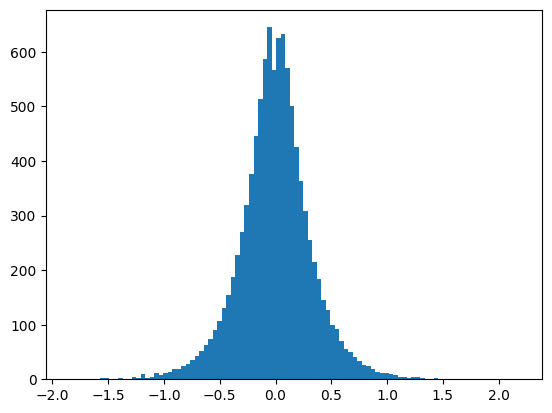

In [1]:
import numpy as np
import random_number_gen
import scipy
import matplotlib.pyplot as plt
gen=random_number_gen.RandomNumberGen()
X=gen.generate_CGMY_Ylessthan1(1000,10,3,5,5,-1.2)  ##test of the CGMY gen for Y<0:
plt.hist(X.flatten(),bins=100)
plt.show()


###Comparing RNGs

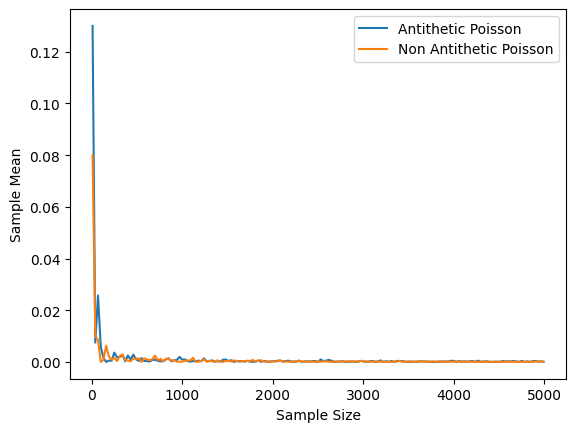

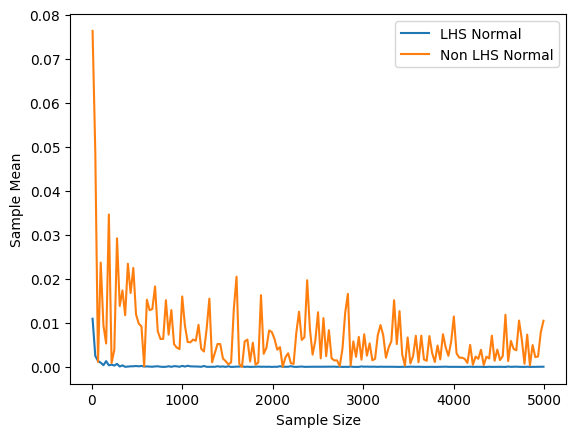

54.8 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.1 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
import numpy as np
from scipy.stats import poisson
import numpy as np
from random_number_gen import RandomNumberGen
from scipy.stats import norm
import matplotlib.pyplot as plt
# Create an instance of RandomNumberGen
rng = RandomNumberGen()
int_range=np.arange(10,5000,30)
# Generate two arrays of Poisson random numbers
A1=[]
A2=[]
for i in int_range:
    poisson1 = rng.generate_poisson(i, 10,5,Antithetic=True) ###Both methods contain LHS so it is not surprising that they are similar in performance
    poisson2 = rng.generate_poisson(i, 10,5,Antithetic=False)
    A1.append(np.abs(np.mean(poisson1)-5))
    A2.append(np.abs(np.mean(poisson2)-5))
plt.plot(int_range,A1,label='Antithetic Poisson')
plt.plot(int_range,A2,label='Non Antithetic Poisson')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
B1=[]
B2=[]

for i in int_range:
    normal1_sample=rng.generate_matrix(i,10,LHS=True)
    normal2_sample=rng.generate_matrix(i,10,LHS=False)
    normal1=norm.ppf(normal1_sample)
    normal2=norm.ppf(normal2_sample)
    B1.append(np.abs(np.mean(normal1)))
    B2.append(np.abs(np.mean(normal2)))
plt.plot(int_range,B1,label='LHS Normal')
plt.plot(int_range,B2,label='Non LHS Normal')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
%timeit rng.generate_matrix(1_000_000,1,LHS=True)
%timeit rng.generate_matrix(1_000_000,1,LHS=False)
# Example usage



###Initial CGMY Characteristic function inversion tests

In [ ]:

from scipy.special import gamma,gammaincc
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy
import random_number_gen
  # Rest of the code...
class CGMY_test():
  def __init__(self, C, G, M, Y, t, error):
    self.C = C
    self.G = G
    self.M = M
    if Y == int(Y):
      self.Y = Y - 0.03  ##to avoid overflow during gamma function evaluation
    else:
      self.Y = Y
    self.t = t
    self.error = error

  def characteristic_function(self,u,t,increment=[0,0,0,0]):

      C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
      return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)

    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)

    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]

    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]

    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)


    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)

    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:


    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    print("Fourier Inversion Parameters:###########")
    print("alpha:", self.alpha)
    self.D = optimization.fun
    print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))

    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    print("L_opt:", L_opt)
    print("h:", h)

    N = np.ceil(L_opt / h)
    print("N:", N)
    eta = self.D / N
    print(  "eta:", eta)





    ###Vectorized Operations for faster computation

    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h


    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index

    M2+=np.ones(len(M2))*0.5

    return x_range,np.real(M2)

# Test the code
cgmy = CGMY(C=240 , G=5, M=5, Y=0.5, t=1/365, error=10e-7)

C=cgmy.generate_cdf()
sample_gen=random_number_gen.RandomNumberGen()
sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0])
hist_values,bins,_=plt.hist(sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0]),bins=100)
Dx=C[0][1]-C[0][0]
D=np.diff(C[1])/Dx

plt.plot(C[0][1:],D*max(hist_values)/max(D))
plt.show()

plt.plot(C[0][1:],D)
plt.plot(C[0],C[1])

plt.show()

###Test of variance reduction techniques

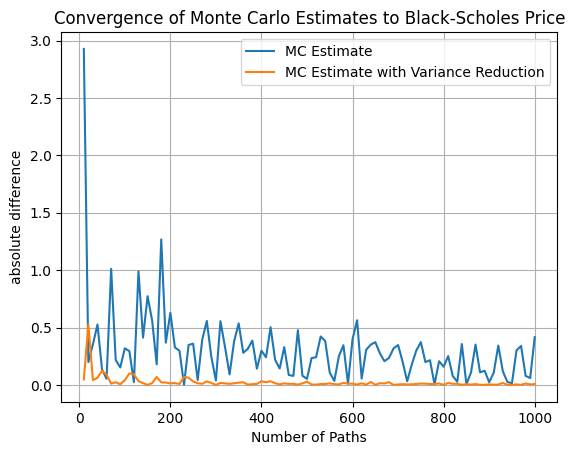

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random_number_gen
gen=random_number_gen.RandomNumberGen()
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_call(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * norm.ppf(np.array(gen.generate_matrix(paths,4,LHS=False)) ) )
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    return call_price_mc
def monte_carlo_call_antithetic(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    sample=norm.ppf(np.array(gen.generate_matrix(paths//2,4,LHS=True)) )
    #np.random.standard_normal(paths//2)
    sample=np.concatenate([sample,-sample])
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sample)
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)

    return call_price_mc

def plot_convergence(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate')


def plot_convergence_antithetic(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call_antithetic(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate with Variance Reduction')
    # plt.plot(paths_range, diff, label='MC Estimate Antithetic')

        plt.xlabel('Number of Paths')
        plt.ylabel('absolute difference')
        plt.title('Convergence of Monte Carlo Estimates to Black-Scholes Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example parameters
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to expiration in years
r = 0.05 # Risk-free rate
sigma = 0.2  # Volatility

# Uncomment below line to execute the plotting function
# %timeit plot_convergence(S, K, T, r, sigma, 100000, 100)
# %timeit plot_convergence_antithetic(S, K, T, r, sigma, 100000, 100)
plot_convergence(S, K, T, r, sigma, 1000, 10,plot=True)
plot_convergence_antithetic(S, K, T, r, sigma, 1000, 10,plot=True)

####Model implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
import math
import random_number_gen
import scipy.optimize as optimize
gen=random_number_gen.RandomNumberGen()
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message="Conversion of an array with ndim > 0 to a scalar is deprecated")


In [96]:
class Merton():
    def __init__(self,mu,sigma,lambda_,muJ,sigmaJ):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.muJ=muJ
        self.sigma_J=sigmaJ
    def simulate_end(self,paths,T,S0=100):
        S=S0*np.exp((self.mu-self.sigma**2/2-self.lambda_*(self.muJ))*T )
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T)
        normal_sample=gen.generate_normal(paths,1)
        max_poisson=np.max(poisson_sample)
        jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
        #%timeit np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        #out = np.array([np.pad(np.ones(int(x)), (0, int(max_poisson - x)), 'constant', constant_values=0) for x in poisson_sample])
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        #%timeit np.sum(np.where(out==1,jump_sample,np.zeros((n,int(max_poisson)))),axis=1) ##matrix of 1s and 0s where the sum of each row is equal to the poisson var
        jump_vect=np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1)[:,np.newaxis]
        #print((self.sigma*math.sqrt(T)*normal_sample).shape)
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*np.exp(jump_vect)
        #print(jump_vect.shape)
        #print(S.shape)
        return S

    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        S=S0*np.ones((paths,N))
        const=np.exp((self.mu-self.sigma**2/2-self.lambda_*(self.muJ))*dt )
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        normal_sample=gen.generate_normal(paths,N)

        for l in range(1,N):
            max_poisson=np.max(poisson_sample[:,l])
            jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
            out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l]])

            S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(dt)*normal_sample[:,l])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))

        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.muJ,self.sigma_J=params
    def update_time(self,T):
        pass
    def prior(self):
        mu = np.random.uniform(-0.4, 0.4)  # Uniform prior for mu
        sigma = np.random.uniform(0.05, 0.35)  # Uniform prior for sigma
        lambda_ = np.random.uniform(0, 0.1)  # Uniform prior for lambda
        muJ = np.random.uniform(-0.4, 0.4)  # Uniform prior for muJ
        sigmaJ = np.random.uniform(0, 0.8)

        return [mu,abs(sigma),abs(lambda_),muJ,abs(sigmaJ)]

X=Merton(0.03,0.15,0.1,-0.08,0.4)
print(np.mean(np.maximum(X.simulate_paths(10000,0.01,12,100)[:,-1]-100,0)))
print(np.mean(np.maximum(X.simulate_end(100000,0.01,100)-100,0))*np.exp(-0.05/100))


0.6151061582912468
0.636657894316989


In [6]:
import math
class Kou():
    def __init__(self,mu,sigma,lambda_,p,eta1,eta2):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.p=p
        self.eta1=eta1
        self.eta2=eta2
    def simulate_end(self,paths,T,S0=100):
        mean=self.p*self.eta1/(self.eta1-1)+(1-self.p)*self.eta2/(self.eta2+1)-1
        #self.p*self.eta1/(self.eta1-1)+(1-self.p)*self.eta2/(self.eta2+1)-1
        #self.p/self.eta1-(1-self.p)/self.eta2
        
        #self.p*self.eta1/(self.eta1-1)+(1-self.p)*self.eta2/(self.eta2+1)-1
        
        #self.mu=self.mu-self.lambda_*(mean) +self.sigma**2/2
        
        S=S0*np.exp((self.mu-self.lambda_*(mean))*T ) #-self.lambda_*(self.p*self.eta1/(self.eta1-1)+(1-self.p)*self.eta2/(self.eta2+1)-1)   -self.sigma**2/2-
        
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T).flatten()
        
        normal_sample=gen.generate_normal(paths,1).flatten()
        
        max_poisson=np.max(poisson_sample)
        U = np.random.uniform(0,1, (1, paths))
        jump_sample = np.zeros((1, paths))
        for i in range(0, len(U[0])):
            for j in range(0, len(U)):
                if U[j,i]>=self.p:
                    jump_sample[j,i]=(-1/self.eta1)*np.log((1-U[j,i])/self.p)
                elif U[j,i]<self.p:
                    jump_sample[j,i]=(1/self.eta2)*np.log(U[j,i]/(1-self.p))
        jump_sample=jump_sample.transpose()
        
        #jump_sample=gen.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
        
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        
        jump_vect=np.prod(np.where(out==1,(np.exp(jump_sample))*out,np.ones((paths,int(max_poisson)))),axis=1)
        
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*jump_vect
                                                           
        
        return S
    def update_time(self,t):
        pass
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params
    def generate_double_exponential(self,paths,n,p,eta1,eta2):
        U = gen.generate_matrix(paths,n)
        jump_sample = np.zeros((paths, n))
        for i in range(0, len(U[0])):
            for j in range(0, len(U)):
                if U[j,i]>=self.p:
                    jump_sample[j,i]=(-1/self.eta1)*np.log((1-U[j,i])/self.p)
                elif U[j,i]<self.p:
                    jump_sample[j,i]=(1/self.eta2)*np.log(U[j,i]/(1-self.p))
        return jump_sample
    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        print(dt)
        S=S0*np.ones((paths,N+1))
        zeta=self.lambda_*(self.p*self.eta1/(self.eta1-1)+(1-self.p)*self.eta2/(self.eta2+1)-1)
        const=np.exp((self.mu-self.sigma**2/2-zeta)*dt )
        print(const)
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        
        normal_sample=gen.generate_normal(paths,N)
        
        for l in np.arange(1,int(N+1)):
            max_poisson=int(np.max(poisson_sample[:,l-1]))
            if max_poisson>1:
                jump_sample=self.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
                out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l-1]])
                S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(dt)*normal_sample[:,l-1])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))
            elif max_poisson==1:
                jump_sample=self.generate_double_exponential(paths,1,self.p,self.eta1,self.eta2).flatten()
                
                S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(dt)*normal_sample[:,l-1])+(np.exp(jump_sample)-1)*poisson_sample[:,l-1]
            else:
                S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(dt)*normal_sample[:,l-1])
               
            
        
        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params
    def prior(self):##for Parameter Estimation later

        mu=np.random.uniform(-0.4,0.4)
        sigma=np.random.uniform(0.05,0.35)
        lambda_=np.random.uniform(0,4)
        p=np.random.uniform(0,1)
        eta1=np.random.uniform(1,5)
        eta2=np.random.uniform(1,5)

        return [mu,abs(sigma),abs(lambda_),p,eta1,eta2]


X=Kou(0.05,0.16,1,0.4,10,5)
S=X.simulate_end(10000,1/2,100)


In [100]:
from scipy.special import gamma,gammaincc
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy
import random_number_gen
import pandas as pd
import mpmath
class CGMY():
  def __init__(self,C,G,M,Y,eta,mu):
      self.C=C
      self.G=G
      self.M=M
      if np.abs(Y-int(Y))<0.05:
        Y-=0.05
      self.Y=Y
      self.eta=eta
      self.generated=False
      self.mu=mu ##risk free rate
      self.L_limit=1024 #limit for interval to consider

  def characteristic_function(self,u,t,increment=[0,0,0,0]):

    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)

    return -C*gamma(-Y)*(M**Y+G**Y)
  def update_L_limit(self,L):
    self.L_limit=L
  def reg_characteristic_function(self,u,t):
   return np.where(
        u != 0,
        -(1 - np.cos(u * self.D)) / (1j * u) * self.characteristic_function(u, t),
        0
    )

  def L_error(self,L,B,b,beta,D,error):
    
    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)*gamma(1/beta)-error
    
    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),method="bounded",bounds=(10,1e8))
    return res.x
  
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    
    return np.exp(-self.t*C*gamma(-Y)*((G**Y-(G-alpha)**Y+M**Y-(M+alpha)**Y)))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X))) #calculate numerical bound for h given C, the bound of A
  
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)

    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]

    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]

    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)


    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)

    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A

  def generate_cdf(self,limit_error=True):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:


    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    #print("Fourier Inversion Parameters:###########")
    #print("alpha:", self.alpha)
    self.D = optimization.fun
    #print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))

    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    #print("L_opt:", L_opt)
    #print("h:", h)
    
    if limit_error:
      L_opt=np.minimum(self.L_limit,L_opt)
    
    N = np.ceil(L_opt / h)
    if N%2!=0:
      N+=1
    
    eta = self.D / N
    #print(  "eta:", eta)
    
    if L_opt==self.L_limit:
      print("additional_max_errror per point due to bounding",(self.D*self.B/(np.pi*self.beta*b**(1/self.beta))*gammaincc(1/self.beta,b*(L_opt/2)**self.beta)*gamma(1/self.beta)-self.error)/N)
      if (self.D*self.B/(np.pi*self.beta*b**(1/self.beta))*gammaincc(1/self.beta,b*(L_opt/2)**self.beta)*gamma(1/self.beta)-self.error)/N>0.001:
        return [0],[0]



    
   
    u_domain = np.arange(-N/2*h, (N/2-1/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2-1/2)*eta, eta)
    out_array=pd.DataFrame({"x_range":x_range})
    
    const = 1/(2*np.pi) * h
    exp_constant=np.exp(-1j*u_domain[0]*(x_range-x_range[0]))
    
    reg_char_func_vect =np.apply_along_axis(lambda u: self.reg_characteristic_function(u, t),0,u_domain)
    const = 1 / (2 * np.pi) * h
    exp_constant = np.exp(-1j * u_domain[0] * (x_range - x_range[0]))
    loop_constant=np.exp(-1j*u_domain*x_range[0])
    
    
    loop_constant=np.exp(-1j*u_domain*x_range[0])
    new_array=[]
    for l,i in enumerate(x_range):
        exp_vector=np.exp(-1j*np.arange(0,int(N),1)*l*h*eta)
        new_array.append(np.sum(loop_constant*exp_vector*reg_char_func_vect))
    out_array["cdf_value"]=new_array
    out_array["cdf_value"]*=const*exp_constant
    out_array+=0.5
    out_array["cdf_value"]=np.real(out_array["cdf_value"])
  
    


    self.CumDensity=(x_range,np.array(out_array["cdf_value"]))
    self.generated=True
    return x_range,np.array(out_array["cdf_value"])
  def generate_inverse_transform_sample(self,n,rows):
    if not self.generated:
      self.generate_cdf()
    return gen.inverse_transform(gen.generate_matrix(n,rows),self.CumDensity[1],self.CumDensity[0])
  def generate_sample(self,n,rows,t,error):
    self.t=t
    self.error=error
    if self.Y>0:
      out=self.generate_inverse_transform_sample(n,rows)
    else:
      out=gen.generate_CGMY_Ylessthan1(n,rows,self.C,self.G,self.M,self.Y)
    return out
  def update_params(self,params):
    self.C,self.G,self.M,self.Y,self.eta=params
    self.generated=False
  def update_time(self,t):
    self.t=t
    self.generated=False
  def calculate_omega(self):
    omega=-np.log(self.characteristic_function(-1j,self.t))/self.t
    return omega
  def simulate_end(self,paths,T,s0,error=10e-15):
    S=s0
    self.generated=False
    cgmy_sample=np.real(self.generate_sample(paths,1,T,error))
    omega=self.calculate_omega()

    S=np.exp((self.mu+omega-self.eta**2/2)*T)*S
    normal_sample=gen.generate_normal(paths,1)

    S=S*np.exp(cgmy_sample)

    S=S*np.exp(self.eta*np.sqrt(T)*normal_sample)

    return np.real(S)
  def simulate_paths(self,paths,T,N,s0,error):
    dt=T/(N)
    S=s0*np.ones((paths,N+1))
    cgmy_sample=np.real(self.generate_sample(paths,N,dt,error))
    omega=np.real(self.calculate_omega())
    const=np.exp((self.mu+omega-self.eta**2/2)*dt)
    normal_sample=gen.generate_normal(paths,N)
    for l in range(1,N+1):
        S[:,l]=S[:,l-1]*const*np.exp(cgmy_sample[:,l-1]+self.eta*np.sqrt(dt)*normal_sample[:,l-1])
    return np.real(S)
  def prior(self): ##arbitrary prior for starting genetic algorithm
    C=np.random.uniform(1,15)
    G=np.random.uniform(1,15) ##Smaller interval in order to avoid overflow in first population, does not stop parameters from going beyond this later on
    M=np.random.uniform(1,15)
    Y=np.random.uniform(-2,1.5)
    if np.abs(Y-int(Y))<0.05: ##avoid early overflow
      Y-=0.05
    eta=np.random.uniform(0,1)
    return [C,G,M,Y,eta]

from scipy.special import gamma
X=CGMY(2,12,12,-0.6,0.04,0.05)
X.prior()
X.simulate_paths(6,1,12,100,10e-10)



array([[100.        ,  89.83166216,  85.3713235 , 103.78280407,
        103.6083358 , 121.90781186, 120.82634159, 116.3172317 ,
        114.90011072, 114.68393311, 113.49973012, 114.88972693,
        116.55166316],
       [100.        , 101.14251612, 103.96353194, 101.13196241,
        104.16052044, 104.73229413, 117.3276374 , 120.00513201,
        130.04074648, 133.32964511, 128.2892992 , 135.93948502,
        149.0738851 ],
       [100.        , 105.54249762, 106.68789374, 106.96688485,
        106.6361695 , 107.07357717, 108.3037793 , 111.95095983,
        112.32613433, 102.40680745, 105.25359785, 102.49925295,
        102.55490166],
       [100.        , 158.27845682, 160.22107803, 157.18675704,
        151.49620493, 160.13620981, 154.16845123, 143.58827785,
        143.27688042, 144.98433307, 147.20373804, 149.00276629,
        139.50323649],
       [100.        , 100.41130988,  97.99748394,  88.53429557,
        120.09567165, 118.34901191, 115.61650297, 118.92366773,
        110.

original L_opt: 353.46945836407326
N: 2892.0
D 25.24714625253596
L 353.46945836407326


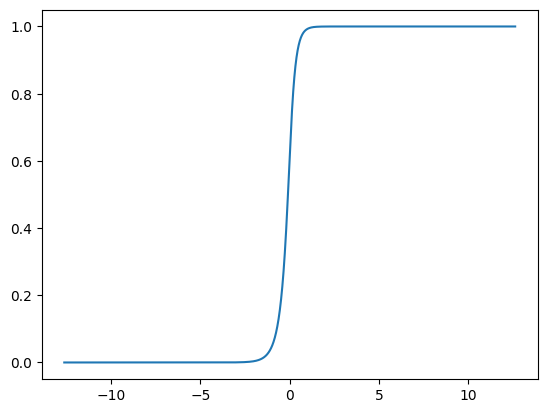

14.069584808006402

In [26]:
test=CGMY(0.5,2,3.5,0.5,0,0.04)
end_price=test.simulate_end(100000,1,100,1e-10)
payoffs=np.mean(np.maximum(-(end_price-100),0))*np.exp(-0.04)
payoffs

###Downloading the Data

In [8]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv

In [16]:
__TICKERS_TO_CHECK=["^SPX","NVDA","AAPL","TSLA","MSFT"]
import yfinance as yf

In [17]:
class Download_data():
    def __init__(self,tickers):
        self.tickers=tickers
        self.columns_to_keep=["contractSymbol",	"strike","volume",	"lastPrice",	"impliedVolatility",	"currency"]
    def download_data(self,ticker,period):
        data=yf.download(ticker,period=period)
        data.log_price=np.diff(np.log(data["Adj Close"]))
        pd.DataFrame(data.log_price).to_csv(f"{ticker}.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_option_chain(self,ticker,nb_strikes,nb_exp):
        YFTICKER=yf.Ticker(ticker)
        option_chain=YFTICKER.option_chain()
        current_price=YFTICKER.history(period="1d")["Close"][0]
        all_exps=pd.DataFrame([datetime.datetime.strptime(l,'%Y-%m-%d')  for l in list(YFTICKER._expirations.keys())])
        all_exps=all_exps.loc[all_exps[0].dt.dayofweek==4]
        print(all_exps)
        #all_exps=all_exps[0].dt.strftime('%Y-%m-%d')
        
        
        exp=all_exps[0][0:nb_exp]
        print(exp)
        output=pd.DataFrame()
        for l in exp:
            l=l.strftime('%Y-%m-%d')
            temp_option_chain=YFTICKER.option_chain(l)
            all_options=temp_option_chain.calls._append(temp_option_chain.puts)
            delta=np.sort(np.abs(np.diff(all_options["strike"])))[0]

            all_options=all_options[all_options["strike"].between(current_price-delta*nb_strikes,current_price+delta*nb_strikes)]
            all_options=all_options[self.columns_to_keep]
            output=pd.concat([output,all_options],ignore_index=True)
        output.to_csv(f"{ticker}_option_chain.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_data(self):
        output={}
        for l in self.tickers:
            try:
                pd.read_csv(f"{l}.csv")
                import os
                import datetime



                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the asset return file matches today's date.")
                else:
                    print("The time from the asset return file does not match today's date.")
                    output.update(self.download_data(l,"1y"))
            except:
                output.update(self.download_data(l,"1y"))
            try:
                pd.read_csv(f"{l}_option_chain.csv")
                import os
                import datetime



                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}_option_chain.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the option chain file matches today's date.")
                else:
                    print("The time from the option chain file does not match today's date.")
                    output.update(self.get_option_chain(l,5,5))
            except:
                output.update(self.get_option_chain(l,5,5))

        return output

x=Download_data(__TICKERS_TO_CHECK)
x.get_data()

The time from the asset return file does not match today's date.


[*********************100%%**********************]  1 of 1 completed
C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


            0
1  2024-06-07
6  2024-06-14
10 2024-06-21
15 2024-06-28
19 2024-07-05
24 2024-07-12
27 2024-07-19
28 2024-07-26
30 2024-08-16
31 2024-08-30
32 2024-09-20
34 2024-10-18
36 2024-11-15
37 2024-11-29
38 2024-12-20
40 2025-01-17
41 2025-02-21
42 2025-03-21
45 2025-05-16
46 2025-06-20
47 2025-12-19
48 2026-03-20
49 2026-12-18
50 2027-12-17
51 2028-12-15
52 2029-12-21
1    2024-06-07
6    2024-06-14
10   2024-06-21
15   2024-06-28
19   2024-07-05
Name: 0, dtype: datetime64[ns]


[*********************100%%**********************]  1 of 1 completed

The time from the asset return file does not match today's date.



C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


            0
0  2024-06-07
1  2024-06-14
2  2024-06-21
3  2024-06-28
4  2024-07-05
5  2024-07-12
6  2024-07-19
7  2024-08-16
8  2024-09-20
9  2024-10-18
10 2024-11-15
11 2024-12-20
12 2025-01-17
13 2025-02-21
14 2025-03-21
15 2025-06-20
16 2025-09-19
17 2025-12-19
18 2026-01-16
20 2026-12-18
0   2024-06-07
1   2024-06-14
2   2024-06-21
3   2024-06-28
4   2024-07-05
Name: 0, dtype: datetime64[ns]
The time from the asset return file does not match today's date.


[*********************100%%**********************]  1 of 1 completed
C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


            0
0  2024-06-07
1  2024-06-14
2  2024-06-21
3  2024-06-28
4  2024-07-05
5  2024-07-12
6  2024-07-19
7  2024-08-16
8  2024-09-20
9  2024-10-18
10 2024-11-15
11 2024-12-20
12 2025-01-17
13 2025-03-21
14 2025-06-20
15 2025-09-19
16 2025-12-19
17 2026-01-16
19 2026-12-18
0   2024-06-07
1   2024-06-14
2   2024-06-21
3   2024-06-28
4   2024-07-05
Name: 0, dtype: datetime64[ns]


[*********************100%%**********************]  1 of 1 completed

The time from the asset return file does not match today's date.
The time from the option chain file does not match today's date.



C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))
C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


            0
0  2024-06-07
1  2024-06-14
2  2024-06-21
3  2024-06-28
4  2024-07-05
5  2024-07-12
6  2024-07-19
7  2024-08-16
8  2024-09-20
9  2024-10-18
10 2024-11-15
11 2024-12-20
12 2025-01-17
13 2025-03-21
14 2025-06-20
15 2025-09-19
16 2025-12-19
17 2026-01-16
19 2026-12-18
0   2024-06-07
1   2024-06-14
2   2024-06-21
3   2024-06-28
4   2024-07-05
Name: 0, dtype: datetime64[ns]


[*********************100%%**********************]  1 of 1 completed

The time from the asset return file does not match today's date.



C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1969425311.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


            0
0  2024-06-07
1  2024-06-14
2  2024-06-21
3  2024-06-28
4  2024-07-05
5  2024-07-12
6  2024-07-19
7  2024-08-16
8  2024-09-20
9  2024-10-18
10 2024-11-15
11 2024-12-20
12 2025-01-17
13 2025-03-21
14 2025-06-20
15 2025-09-19
16 2025-12-19
17 2026-01-16
19 2026-12-18
0   2024-06-07
1   2024-06-14
2   2024-06-21
3   2024-06-28
4   2024-07-05
Name: 0, dtype: datetime64[ns]


{'2024-06-06': 'MSFT'}

###Calculating Option Prices:

C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\1754583523.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.plot_option_prices(pd.read_csv("TSLA_option_chain.csv"),yf.Ticker("TSLA").history(period="1d")["Close"][0],1500,model)


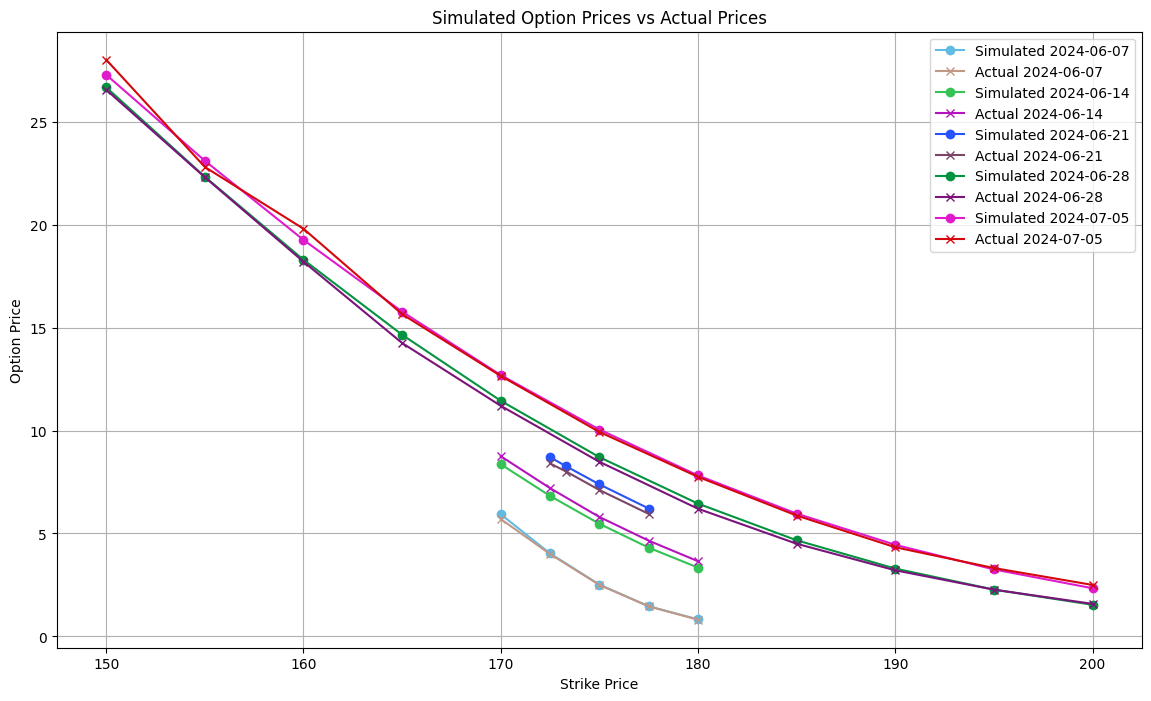

In [102]:
class Option_Price_Calculator():
    def __init__(self):
        self.discount_rate=0.05
        pass
    def transform_into_df(self,option_names):
        ext=option_names.str.extract(r'(\D{4})(\d{6})(\D)(\d+)', expand=True)
        ext.columns=["Ticker","Date","Type","Strike"]
        
        ext.to_csv("test.csv")
    
        ext.Date=pd.to_datetime(ext.Date,format="%y%m%d")
        ext.Strike=ext.Strike.astype(float)/1000
        out=pd.concat([option_names,ext],axis=1)
        out.columns=["Option","Ticker","Date","Type","Strike"]
        return out
    def price_options(self,option_chain,s0,nb_simulations,model):
        X=self.transform_into_df(option_chain["contractSymbol"])
        all_sims=pd.DataFrame()

        X["Sim_price"]=np.nan
        for l in X.Date.unique():

            time_to_exp=((l-pd.Timestamp.today()).days+1)/250
            model.update_time(time_to_exp)
            try:
                sim=np.real(model.simulate_end(nb_simulations,time_to_exp,s0))
            except:
                X["Sim_price"]=s0
                return X
            
            sim=pd.DataFrame(sim,columns=[datetime.datetime.strftime(l,"%Y-%m-%d")])
            all_sims=pd.concat([all_sims,pd.DataFrame(sim)],axis=1)

        for i,j in enumerate(X.Date):
            Delay=((j-pd.Timestamp.today()).days+1)/250
            index=datetime.datetime.strftime(j,"%Y-%m-%d")

            exp_S=s0*np.exp(Delay*self.discount_rate)

            sim_prices=all_sims[index]
            if X.Type[i]=="C":
                Exp_price=np.maximum(sim_prices-X.Strike[i],0)

            else:
                Exp_price=np.maximum(X.Strike[i]-sim_prices,0)


            try:
                b_hat=np.cov(sim_prices,Exp_price)[0,1]/np.var(sim_prices) ##control variate coefficient
                Control_Var_adj=Exp_price-b_hat*(all_sims[index]-exp_S)
            except RuntimeWarning as p:
                Control_Var_adj=s0




            X.loc[i,"Sim_price"]=max(np.exp(-Delay*self.discount_rate)*np.mean(Control_Var_adj),0)
        return X
    def Option_error(self,option_chain,s0,nb_simulations,model,metric="MSE"):
        X=self.price_options(option_chain,s0,nb_simulations,model)

        if metric=="MAE":
            return np.mean(np.abs(option_chain.lastPrice-X.Sim_price)/option_chain.lastPrice*100)
        elif metric=="MSE":
            return np.mean((option_chain.lastPrice-X.Sim_price)**2)
        return X
    def error_vector(self,option_chain,s0,nb_simulations,model,metric="MAE"):
        X=self.price_options(option_chain,s0,nb_simulations,model)
        return np.abs(option_chain.lastPrice-X.Sim_price)
    def plot_option_prices(self, option_chain, s0, nb_simulations, model):
        X = self.price_options(option_chain, s0, nb_simulations, model)

        # Plot actual prices vs. simulated prices
        plt.figure(figsize=(14, 8))

        for date in X.Date.unique():
            subset = X[X.Date == date]
            subset = subset[subset.Type == "C"]
            random_market_color = "#" + ''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
            random_simulated_color = "#" + ''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])

            # Plotting with lines connecting the points
            plt.plot(subset.Strike, subset.Sim_price, color=random_market_color, label=f"Simulated {date.date()}", marker='o', linestyle='-')
            plt.plot(subset.Strike, option_chain[option_chain['contractSymbol'].isin(subset.Option)].lastPrice, color=random_simulated_color, label=f"Actual {date.date()}", marker='x', linestyle='-')

        plt.xlabel('Strike Price')
        plt.ylabel('Option Price')
        plt.title('Simulated Option Prices vs Actual Prices')
        
        plt.legend()
        plt.grid(True)
        plt.show()
p=Option_Price_Calculator()
model=CGMY(3.65650208544521,	10.552259665368963,	23.471839073080883,	-0.2997026361670687,	0.3821798201695674



,0.05



)
p.plot_option_prices(pd.read_csv("TSLA_option_chain.csv"),yf.Ticker("TSLA").history(period="1d")["Close"][0],1500,model)
#print(p.Option_error(pd.read_csv("AAPL_option_chain.csv"),180,1000,CGMY(5,12,12,-0.6,0.04,0.05)))
#Price=p.price_options(pd.read_csv("AAPL_option_chain.csv"),180,1000,CGMY(5,12,12,-0.6,0.04,0.05))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats


class RandomWalkMetropolisHastings:
    def __init__(self, initial_state, proposal_params, data, model,limits,special=0,memory=100):
        self.state = initial_state
        self.proposal_params = proposal_params
        self.data = data["0"]
        self.model = model
        self.accepted = 0
        self.rejected = 0
        self.likelihoods = []
        self.log_like=-np.inf
        self.min=limits[:,0]
        self.max=limits[:,1]
        self.special=special
        self.lambda_=0.1
        self.max_likelihood=-np.inf
        self.max_state=initial_state
        self.history=[]
        self.memory=memory
        

    def step(self):

        proposed_state = self.proposal_distribution(self.state, self.proposal_params)
        if not( np.all((proposed_state >= self.min) & (proposed_state <= self.max))):
            return self.state
        try:
            new_ll = self.log_likelihood(proposed_state)#+np.log(self.model.prior(proposed_state))
        except RuntimeWarning as e:
            new_ll = -50
        except RuntimeError as e:
            new_ll = -50

        current_ll = self.log_like#+np.log(self.model.prior(self.state))
        if new_ll>self.max_likelihood:
            self.max_likelihood=new_ll
            self.max_state=proposed_state
        log_alpha = new_ll - current_ll

        if np.log(gen.Scrambled_Random()) < log_alpha:
            self.state = proposed_state
            self.accepted += 1
            self.log_like = new_ll
            self.likelihoods.append(new_ll)
            self.history.append(proposed_state)
        else:
            self.rejected += 1
            self.likelihoods.append(current_ll)
            self.history.append(self.state)
        if self.k>self.memory:
            self.history=self.history[1:]
        return self.state
    def reset_acceptance(self):
        self.accepted=0
        self.rejected=0

    def run(self):
        stop=False
        self.k=0
        while True:
            self.k+=1
            self.step()
            if self.k % 100 == 0:
                #print(f"Step {k}, Acceptance Rate: {self.acceptance_rate():.2f}")
                if self.acceptance_rate()>0.9:  ## early stopping if acceptance rate is too high <=> odd behavior
                    stop=True
                    break


                if self.acceptance_rate()<0.01: ## early stopping if not enough new samples are discovered
                    break
                self.reset_acceptance()
        if stop:#early stopping
            return        0,0
        self.state=self.max_state
        self.log_like=self.max_likelihood


        if self.likelihoods==[]:
           return 0,0

        return self.likelihoods[-1],self.state

    def acceptance_rate(self):
        return self.accepted / (self.accepted + self.rejected+10e-9)

    def simulate_pdf(self, n):
        try:
            sims = np.array(self.model.simulate_end(n, 1/365, 1))
        except:
            return 0
        sims = sims.reshape(len(sims))
        log_returns = np.diff(np.log(sims))
        kde = gaussian_kde(log_returns)
        if self.special==1:
            try:
                x=self.model.generate_cdf()[0]
            except UnboundLocalError as e:

                return 0

        else:

            x = np.linspace(min(self.data) - 0.05, max(self.data) + 0.05, 400)
        pdf = kde(x)

        #pdf=pdf/np.1sum(pdf)
          ### in case of overshooting the pdf in bounds by too much, penalize the entire pdf so this parameter setting is not chosen
        return x, pdf

    def log_likelihood(self, state):



        self.model.update_params(state)
        saved = self.simulate_pdf(500)
        if saved==0:
            return -500
        likelihood = np.sum(np.log(np.interp(self.data, saved[0], saved[1], left=1e-10, right=1e-10)))  # Avoid log(0)
        return likelihood-self.lambda_*np.std(saved[1])

    def proposal_distribution(self, state, params):
        selected = np.random.choice(len(state))
        s_d=(2.4**2)/len(self.state)
        
        if self.k<=self.memory: ##for adaptative proposal candiate technique
            
            new_state=state + np.concatenate([[0]*selected,[np.random.normal(0, self.proposal_params)[selected]],[0]*(len(params)-selected-1)])
            
            return new_state
        else:
            cov_matrix = np.cov(np.array(self.history).T)
        
            # Update the proposal distribution's covariance matrix
            self.proposal_params = (1 - 1 / (self.k + 1)) * np.array(self.proposal_params) + (1 / (self.k + 1)) * cov_matrix
            
            # Generate a new proposal from the updated proposal distribution
           
            proposal = np.random.multivariate_normal(state, self.proposal_params)
            return proposal
        




X=RandomWalkMetropolisHastings([1.2,2,2,-0.05,0.1],[0.5, 0.3, 0.3, 0.02, 0.01],pd.read_csv("AAPL.csv"),CGMY(0.05,0.1,0.01,-0.05,0.05,0.1),np.array([[0, np.inf], [1, np.inf], [1, np.inf], [-np.inf, 1.9], [-np.inf, np.inf]]))
X.run()


NameError: name 'CGMY' is not defined

In [6]:
import concurrent.futures
def run_with_timeout(func, args=(), kwargs={}, timeout=5): ##initial method for running optimization algorithms with timeout for odd parameters that lead to long time or crashes
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(func, *args, **kwargs)
        try:
            result = future.result(timeout=timeout)
            return result
        except concurrent.futures.TimeoutError:
            return "Function call timed out"
        

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import json

class ModelTrainer:
    def __init__(self, price_data,ticker):
        self.price_data = price_data
        self.results = {}
        self.ticker=ticker

    def rand_params(self):
        return [np.random.uniform(10, 140), np.random.uniform(1, 25), np.random.uniform(1, 25), np.random.uniform(-3, 1.9), np.random.uniform(-0.1, 0.1)]

    def rand_kou_params(self):
        mu = np.random.uniform(-0.1, 0.1)
        sigma = np.random.uniform(0.01, 0.2)
        lambda_ = np.random.uniform(0.01, 0.1)
        p = np.random.uniform(0.1, 0.9)
        eta1 = np.random.uniform(0.01, 0.1)
        eta2 = np.random.uniform(0.01, 0.1)
        return [mu, sigma, lambda_, p, eta1, eta2]

    def get_random_initial_state(self, limits):
        return np.array([np.random.uniform(l[0], l[1]) for l in limits])

    def train_cgmy(self):
        CGMY_limits = np.array([[0, np.inf], [1, np.inf], [1, np.inf], [-np.inf, 1.9], [-np.inf, np.inf]])
        results = []
        for _ in range(10):
            initial_params = self.rand_params()
            CGMY_sim = RandomWalkMetropolisHastings(
                initial_state=initial_params,
                proposal_params=[0.5, 0.3, 0.3, 0.02, 0.01],
                data=self.price_data,
                model=CGMY(*initial_params, 0.05),
                limits=CGMY_limits,
                special=0
            )
            try:
                x = run_with_timeout(CGMY_sim.run, timeout=1)
                results.append([CGMY_sim.max_likelihood, CGMY_sim.max_state])
            except Exception as e:
                print(e)
                continue

        best_result = max(results, key=lambda x: x[0])
        self.results['CGMY'] = best_result
        self.save_results('CGMY')
        self.visualize_model('CGMY', best_result,algorithm=CGMY_sim)

    def train_merton(self):
        Merton_limits = np.array([(0, np.inf), (0, np.inf), (0, np.inf), (-np.inf, np.inf), (0, np.inf)])
        bounds = [(-0.4, 0.4), (0, 0.4), (0, 0.02), (-0.4, 0.4), (0, 0.4)]
        results = []
        for _ in range(10):
            state = self.get_random_initial_state(bounds)
            X = RandomWalkMetropolisHastings(
                initial_state=state,
                proposal_params=[0.05, 0.1, 0.01, 0.1, 0.1],
                data=self.price_data,
                model=Merton(*state),
                limits=Merton_limits
            )
            exit = X.run()
            results.append(exit)

        best_exit = max(results, key=lambda x: x[0])
        self.results['Merton'] = best_exit
        self.save_results('Merton')
        self.visualize_model('Merton', best_exit,algorithm=X)

    def train_kou(self):
        Kou_limits = np.array([[0.01, np.inf], [0.01, np.inf], [0.01, np.inf], [0, 1], [0.01, np.inf], [0.01, np.inf]])
        results = []
        for _ in range(3):
            Y = RandomWalkMetropolisHastings(
                initial_state=self.rand_kou_params(),
                proposal_params=[0.01, 0.05, 0.001, 0.05, 0.03, 0.05],
                data=self.price_data,
                model=Kou(0.05, 0.1, 0.01, 0.5, 0.1, 0.1),
                limits=Kou_limits
            )
            Y.run()
            results.append((Y.max_likelihood, Y.max_state))
        
        best_result = max(results, key=lambda x: x[0])
        self.results['Kou'] = best_result
        self.save_results('Kou')
        self.visualize_model('Kou', best_result,algorithm=Y)

    def save_results(self, model_name):
        result = self.results[model_name]
        try:
            res = result[1].tolist()
        except:
            res=results
        with open(f'{model_name}_{self.ticker}_results.json', 'w') as file:
            json.dump(res, file)

    def visualize_model(self, model_name, best_result,algorithm=None):
        if model_name == 'CGMY':
            model = CGMY(*best_result[1], 0.05)
        elif model_name == 'Merton':
            model = Merton(*best_result[1])
        elif model_name == 'Kou':
            model = Kou(*best_result[1])

        P = model.simulate_end(366, 1/365, 100)
        P = np.diff(np.log(np.array(P).transpose()))[0]

        hist_data, bins, _ = plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')

        algorithm.model=model
        x,pdf=algorithm.simulate_pdf(1000)
        plt.plot(x,pdf*hist_data[len(hist_data)//2]/max(pdf),label=f'{model_name}Simulated PDF')

        plt.figure(figsize=(12, 6))
        #plt.plot(bins[:-1], pdf, label=f'{model_name} Model PDF')
        plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')
        plt.title(f'{model_name} Model Simulated vs. Historical Log Returns')
        plt.legend()

        plt.show()

    def visualize_all_models(self):
        plt.figure(figsize=(12, 6))

        hist_data, bins, _ = plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')

        MH=RandomWalkMetropolisHastings([0.05, 0.1, 0.01, -0.05, 0.1],[0.05, 0.1, 0.01, 0.1, 0.1],self.price_data,Merton(0.05, 0.1, 0.01, -0.05, 0.1),np.array([(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(0,np.inf)]))
        for model_name, result in self.results.items():
            if model_name == 'CGMY':
                model = CGMY(*result[1], 0.05)
            elif model_name == 'Merton':
                model = Merton(*result[1])
            elif model_name == 'Kou':
                model = Kou(*result[1])

            P = model.simulate_end(366, 1/365, 100)
            P = np.diff(np.log(np.array(P).transpose()))[0]
            MH.model=model
            x,pdf =MH.simulate_pdf(1000)
            plt.plot(x,pdf*hist_data[len(hist_data)//2]/max(pdf), label=f'{model_name} Model PDF')

        plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g', label='Historical Data')
        plt.title('All Models Simulated vs. Historical Log Returns')
        plt.legend()

        plt.show()
# Usage example:
# price_data = load_your_price_data_function()



C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\3832347599.py:147: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  proposal = np.random.multivariate_normal(state, self.proposal_params)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


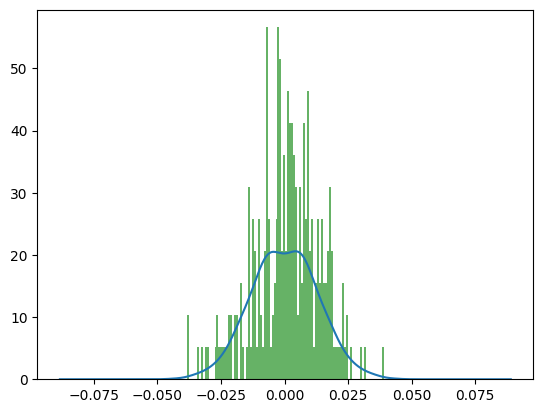

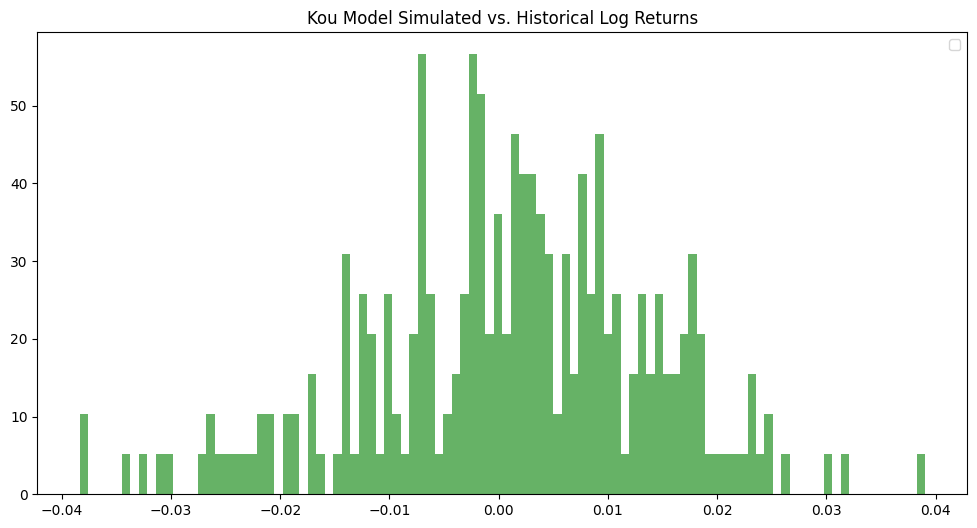

In [20]:
train_data=["MSFT"]
for l in train_data:
    trainer=ModelTrainer(pd.read_csv(f"{l}.csv"),l)

    trainer.train_kou()

C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\847593350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]
C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\1126342054.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


log-Likelihood for CGMY for MSFT=1452.2749686809468
log-Likelihood for Kou for MSFT=1494.5528101161035
log-Likelihood for Merton for MSFT=1494.2611253398445


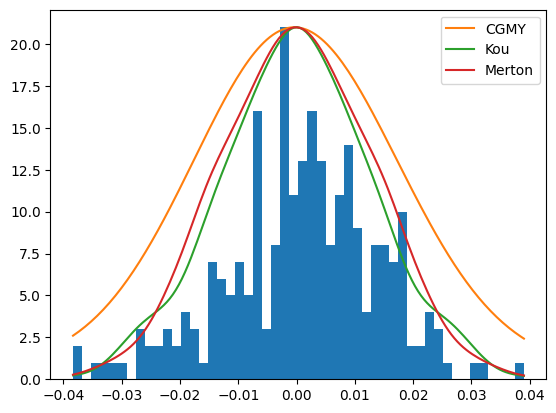

C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\847593350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]
C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\1126342054.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


log-Likelihood for CGMY for TSLA=1301.494122038909
log-Likelihood for Kou for TSLA=1273.4287104480686
log-Likelihood for Merton for TSLA=1290.535814637695


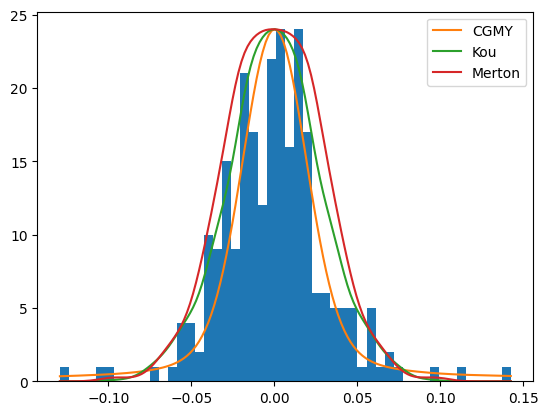

C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\847593350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]
C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\1126342054.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


log-Likelihood for CGMY for AAPL=1534.2774481025167
log-Likelihood for Kou for AAPL=1498.207632846199
log-Likelihood for Merton for AAPL=1517.5348525800316


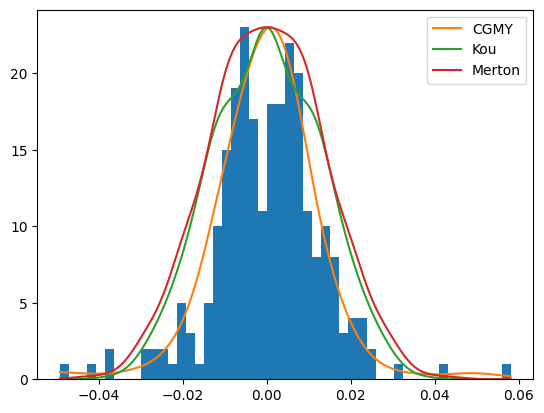

C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\847593350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]
C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\1126342054.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


log-Likelihood for CGMY for ^SPX=1609.7240842416923
log-Likelihood for Kou for ^SPX=1626.8991262896684
log-Likelihood for Merton for ^SPX=1629.0037775662397


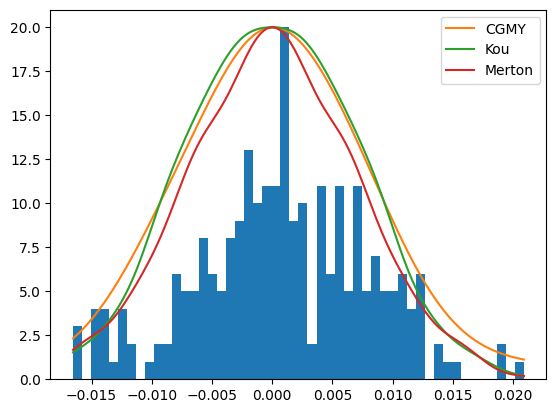

log-Likelihood for CGMY for NVDA=1347.185008414605
log-Likelihood for Kou for NVDA=1318.6940628118346
log-Likelihood for Merton for NVDA=1307.00124509947


C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\847593350.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]
C:\Users\Bram\AppData\Local\Temp\ipykernel_32532\1126342054.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])


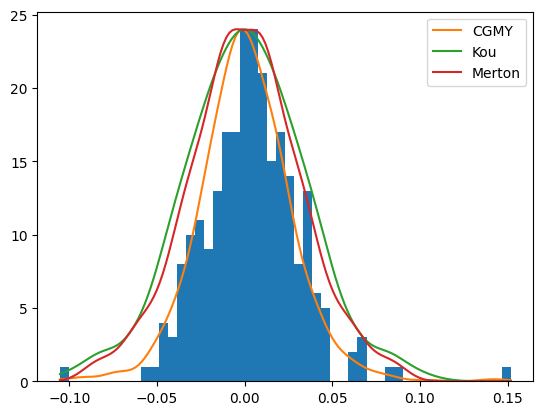

In [59]:
def visualize_models(ticker): ##method for running the algorithm for every model and asset and visualizing the results
    ##Note that the scaling factor is meant to have the max of the KDEs match the top of histogram in order to visualize shape. It does not represent the actual likelihood of the model
    current_price=yf.Ticker(ticker).history(period="1d")["Close"][0]

    cgmy_params=json.load(open(f"CGMY_{ticker}_results.json"))
 
    cgmy_model=CGMY(*cgmy_params,0.05)
    
    cgmy_sample=np.array(cgmy_model.simulate_end(1000,1/365,current_price)).flatten()
    
    cgmy_sample=np.diff(np.log(cgmy_sample))
    
    kou_params=json.load(open(f'Kou_{ticker}_results.json'))
    kou_model=Kou(*kou_params)
    kou_simulations=kou_model.simulate_end(1000,1/365,current_price)
    kou_sample=np.diff(np.log(kou_simulations))
    Merton_params=json.load(open(f"Merton_{ticker}_results.json"))
    Merton_model=Merton(*Merton_params)
    Merton_simulations=np.array(Merton_model.simulate_end(1000,1/365,current_price)).flatten()
    Merton_sample=np.diff(np.log(Merton_simulations))
    cgmy_kde=gaussian_kde(cgmy_sample)
    kou_kde=gaussian_kde(kou_sample)
    Merton_kde=gaussian_kde(Merton_sample)
    data=pd.read_csv(f"{ticker}.csv")["0"]
   
    interval=np.linspace(min(data),max(data),150)
    
    x,y,_=plt.hist(data,bins=50)
    scaling_factor=max(x)
    cgmy_KDE=cgmy_kde(interval)*scaling_factor
    kou_KDE=kou_kde(interval)*scaling_factor
    Merton_KDE=Merton_kde(interval)*scaling_factor
    cgmy_likelihood=log_likelihood((interval,cgmy_KDE),data)
    kou_likelihood=log_likelihood((interval,kou_KDE),data)
    Merton_likelihood=log_likelihood((interval,Merton_KDE),data)
    print(f"log-Likelihood for CGMY for {ticker}={cgmy_likelihood}")
    print(f"log-Likelihood for Kou for {ticker}={kou_likelihood}")
    print(f"log-Likelihood for Merton for {ticker}={Merton_likelihood}")
    plt.plot(interval,cgmy_KDE/max(cgmy_KDE)*max(x),label="CGMY")
    plt.plot(interval,kou_KDE/max(kou_KDE)*max(x),label="Kou")
    plt.plot(interval,Merton_KDE/max(Merton_KDE)*max(x),label="Merton")
    plt.legend()
    plt.show()


def log_likelihood(saved,data ):



    
    if saved==0:
        return -500
    likelihood = np.sum(np.log(np.interp(data, saved[0], saved[1], left=1e-10, right=1e-10)))  # Avoid log(0)
    return likelihood
for i in ["MSFT","TSLA","AAPL","^SPX","NVDA"]:
    visualize_models(i)

In [12]:
import json
class GeneticAlgorithm():
    def __init__(self,model,price_data,limits,sample_size,beta=0.31,original_price=100,ticker="TSLA"):
        self.model=model
        self.price_data=price_data
        self.limits=limits
        self.param_size=len(limits)
        self.sample_size=sample_size
        self.beta=beta
        self.option_pricer=Option_Price_Calculator()
        self.errors=[]
        self.min_errors=[400]
        self.max_errors=[]
        self.min_states=[[0]*self.param_size]
        self.normal_sample_size=self.sample_size ##in order to periodically return to original sample size
        self.original_price=original_price
        self.ticker=ticker
    def errorfunc(self,states):

        ErrorVector=[]
        for i,l in states.iterrows():

            self.model.update_params(l[0:self.param_size])

            error=self.option_pricer.Option_error(self.price_data,self.original_price,2000,self.model,metric="MSE")

            ErrorVector.append(error)
        
        self.max_errors.append(np.max(ErrorVector))
        self.min_errors.append(np.min(ErrorVector))
        self.min_states.append(states.loc[np.argmin(ErrorVector)])
        self.errors.append(np.mean(ErrorVector))
        return ErrorVector
    def check_bounds(self,states):
        #states=pd.DataFrame(states)

        return [i.clip(self.limits[:,0],self.limits[:,1]) for i in states]

    def initial_states(self,n):

        X=[self.model.prior() for _ in range(n)]
        return X
    def diversity_metric(self, states):
    # Calculate pairwise distance between solutions to measure diversity
        distances = np.sum(np.abs(states[:, None] - states), axis=2)
        avg_distance = np.mean(distances)
        return avg_distance
    def update_beta(self, iteration, max_iterations):
    # Gradually increase beta to enhance selection pressure over time
        self.beta = 0.1 + 0.9 * (iteration / max_iterations)

    def mutate(self, states):
        states=np.array(states)
        diversity = self.diversity_metric(states)
        print("diversityrate",diversity)
        mutation_rate = 0.4 if diversity < 2 else 0.15
        new_states = np.array(states, copy=True)
        for i, state in enumerate(states):
            param_index = np.random.randint(0, self.param_size)
            mutation_factor = 1 + mutation_rate * np.random.normal()
            if gen.Scrambled_Random()<0.05:

              new_states[i,:]=state*(1+gen.generate_normal(self.param_size,1,0,mutation_rate,Antithetic=False)[0])
            else:
              new_states[i][param_index] = state[param_index] * mutation_factor
        return self.check_bounds(new_states)

    def bitwise_crossover(self, states):
        x = np.array(states)

        num_parents = x.shape[0]
        offspring = []
        np.random.shuffle(x)

        for i in range(num_parents // 2):
            parent1 = x[2 * i]
            parent2 = x[2 * i + 1]

            child1 = parent1.copy()
            child2 = parent2.copy()

            crossover_points = np.random.randint(0, 2, self.param_size).astype(bool)

            child1[crossover_points] = parent2[crossover_points]
            child2[crossover_points] = parent1[crossover_points]

            offspring.append(child1)
            offspring.append(child2)

        return np.array(offspring)

    def crossover(self,states):
        x=np.array(states)


        s1 = np.random.choice(range(x.shape[0]), int(len(states)//2), replace=False)
        s2 = list(set(range(x.shape[0])) - set(s1))

        # extract your samples:
        sample1 = x[s1,  :]
        sample2 = x[s2,  :]

        m=len(s1)
        unif=gen.generate_matrix(m,1).reshape(-1,1)
        unif2=gen.generate_matrix(m,1).reshape(-1,1)
        new_states=np.concatenate([sample1*unif+sample2*(1-unif),sample1*unif2+(1-unif2)*sample2,states],axis=0)
        self.sample_size=len(new_states)
        print("new_size",self.sample_size)
        return new_states
        pass


    def select(self,states,n): #selection pressure increases as n goes to infinity
        states=pd.DataFrame(states)

        errors=self.errorfunc(states)
        print(np.mean(errors))
        
        states["id"]=states.index
        scaled_errors=-n**self.beta*np.array(errors)
        states["scaled_error"]=np.exp(scaled_errors)
        normal_probs=np.exp(scaled_errors)

        selected_=states.loc[gen.generate_matrix(self.sample_size,1).flatten()<=normal_probs]

        end=np.zeros(self.sample_size)
        for l,i in selected_.iterrows():
            end[int(i.id)]=int(i.id)

        for i,j in states.iterrows():
            if j.id in end:
                pass
            else:
                l=states.copy()



                sumerror=np.sum(np.exp(l.scaled_error))

                l["prob"]=np.exp(l.scaled_error)/sumerror
                l["cumsum"]=np.cumsum(l.prob)


                sample=gen.generate_matrix(1,1)[0]*np.ones(self.sample_size)
                selectedid=l[l["cumsum"]>=sample].id.values[0]
                end[i]=selectedid




        m=pd.concat([states,pd.DataFrame(end,columns=["selected"])],axis=1)

        return self.check_bounds(m.selected.map(lambda x: states.loc[x].values[:-2]))
    def reduce_size(self,states):
        l=pd.DataFrame(states).copy()
        errors=self.errorfunc(l)

        l["error"]=errors
        l=l.sort_values("error")

        self.sample_size=self.normal_sample_size
        if len(self.min_states)>int(0.1*self.normal_sample_size):
            new_size=int(self.normal_sample_size*0.9)
            best_size=self.normal_sample_size-new_size
            ret_matrix=l.iloc[0:new_size][range(self.param_size)].values
           
            best_min_states=pd.concat([pd.DataFrame(self.min_states),pd.DataFrame(self.min_errors,columns=["error"])],axis=1).sort_values("error")[0:best_size]
            return np.concatenate([ret_matrix,best_min_states[range(self.param_size)].values])

        else:
            return l.iloc[0:self.normal_sample_size][range(self.param_size)].values



    def run(self,n,m=0,type_="bit"):
        Theta=self.initial_states(n)
        print(Theta)
        l=0
        self.n=n
        if m==0:
            while  l<100:
                print(l)
                l+=1
                #self.beta+=0.2
                self.update_beta(l,100)
                Theta=self.mutate(Theta)
                Theta=self.select(Theta,l)
                if type_=="bit":
                  Theta=self.bitwise_crossover(Theta)
                else:
                  Theta=self.crossover(Theta)
                Theta=self.select(Theta,l)
                if l%2==0:
                    Theta=self.reduce_size(Theta)
                
        else:
            for i in range(m):
                print(l)
                l+=1
                #self.beta+=0.2
                self.update_beta(l,100)
                Theta=self.mutate(Theta)
                Theta=self.select(Theta,l)
                if type_=="bit":
                  Theta=self.bitwise_crossover(Theta)
                else:
                  Theta=self.crossover(Theta)

                Theta=self.select(Theta,l)
                if l%2==0:
                    Theta=self.reduce_size(Theta)
                
        best_state=pd.concat([pd.DataFrame(self.min_states),pd.DataFrame(self.min_errors,columns=["error"])],axis=1).sort_values("error")
        best_state.to_csv(f"{self.ticker}_min_states.csv")
        plt.plot(self.errors[3:],label="Mean Error",color="red")
        plt.plot(self.min_errors[3:],label="Min Error",color="blue")
        #plt.plot(self.max_errors[3:],label="Max Error",color="green")
        plt.legend()
        plt.show()
        
        return Theta



C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\2057782547.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)


[[-0.12687924970446168, 0.29696527436972187, 0.010984725958178477, 0.3751491156566822, 0.36551196998090846], [0.17831281708001456, 0.3265219250773179, 0.0473526734298391, 0.37076672152106693, 0.24202013901148656], [-0.14861430708940476, 0.14106982236542726, 0.04494644271565549, -0.37762115052021117, 0.7724829072596693], [0.08194378987799206, 0.15095735177826652, 0.04639186414562135, -0.17985258780110033, 0.38459660455038946], [-0.3397793481955635, 0.3064985821476473, 0.08801042339729082, -0.23802977354479957, 0.4050112828115146], [-0.119194843404612, 0.1105007456335509, 0.0032884973241311902, 0.03958355908346034, 0.49548960635243483], [0.32615777280385383, 0.10556387173789857, 0.045099484449296526, -0.1840958075508156, 0.35804941568542886], [-0.14014388852134746, 0.16769318061263494, 0.07513963988984462, -0.009427385013528133, 0.25692613223123856], [-0.0060512042893744455, 0.2776986306326405, 0.07106422242246264, 0.23084862539289241, 0.25247387735581184], [-0.27851036940494844, 0.11747

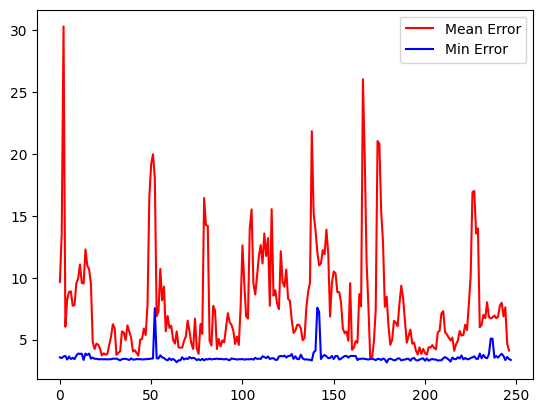

C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\2057782547.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)


[[-0.31092168526216785, 0.3398789429259399, 0.019503787813343988, -0.14677938979982852, 0.18304470772330586], [-0.2651820157935948, 0.06851696582935396, 0.049535130090909624, -0.17060632260463687, 0.4179627110790592], [-0.08709696068324552, 0.19020791888595223, 0.04271431449753519, -0.3558512542773894, 0.12024202657340544], [-0.1533085803078702, 0.2327977433979485, 0.06222793449435393, 0.36255766631703323, 0.7934920253564192], [0.07012527486180425, 0.10137376471834154, 0.09611504350776083, 0.2298613499599378, 0.6748598851035436], [0.08111772056119715, 0.17783748577819497, 0.05638665567465311, 0.10067539273688753, 0.7070692093709401], [-0.21542001426147017, 0.33323662740572474, 0.07617045081562486, -0.10700990956842854, 0.7829760809145307], [-0.3533368014076856, 0.07229843989828785, 0.0987062241202302, 0.3363702727201229, 0.20527588681753023], [0.04171697010952763, 0.15975927034884296, 0.04195567410319767, -0.07491540909767236, 0.13872799093352237], [0.23545671154576153, 0.2535541931287

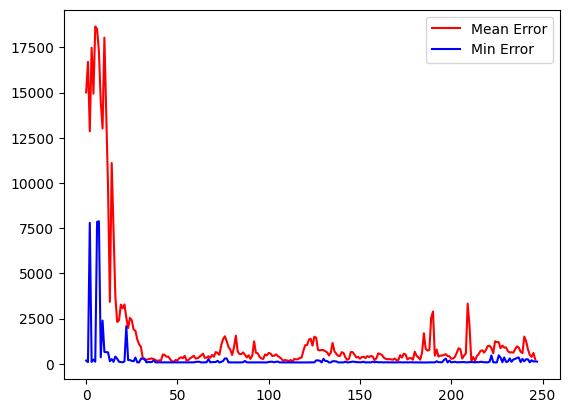

C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\2057782547.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)


[[-0.15677892489244494, 0.0742027511332102, 0.06642490135860561, -0.1323324673065982, 0.20365532501956346], [0.28402973143977683, 0.19042990909150886, 0.030535186772924373, 0.2104685037293741, 0.7648804997181516], [0.3233388993672258, 0.12320465389742806, 0.07946261790064289, -0.22750635642225278, 0.4585757432321449], [-0.16404315577934137, 0.31595611599980505, 0.010763138169213204, -0.3755473257618631, 0.5737007978072299], [-0.1332983470217851, 0.2302028077154909, 0.07701726267422684, -0.22246618818141384, 0.2973614168973317], [0.04863959662498479, 0.16364842928544018, 0.021278754887001452, -0.32620077673369474, 0.30521564016723046], [0.3349207478563617, 0.15722241880259002, 0.04692937370283062, 0.11806668054742464, 0.2184144018262263], [0.20661612173155053, 0.24828052561467928, 0.08090100846816338, -0.21522544253865583, 0.7694323188621399], [-0.2464529480367401, 0.22372639169314318, 0.015446055023517381, -0.02713264560704387, 0.5194210836208176], [-0.018455474968541996, 0.15231327086

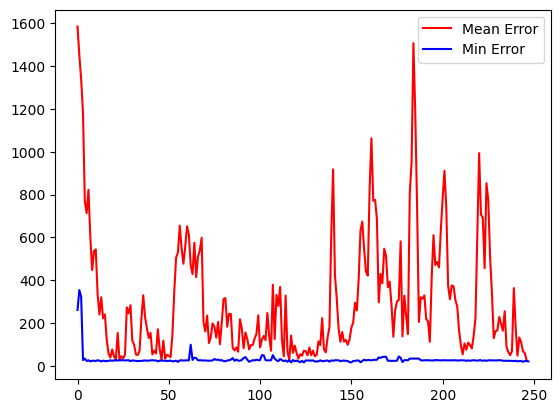

C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\2057782547.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)


[[0.10171756415932953, 0.11703724480016386, 0.012546521073277717, 0.388200362464053, 0.4838475517080566], [0.3465654188065457, 0.29929399727125156, 0.01965058675406908, 0.10076621512563166, 0.6021773092236273], [-0.38542764676038116, 0.1000128173272686, 0.024568502221356092, 0.3696622871726444, 0.27528746764328904], [0.03807976789118939, 0.2871534311643174, 0.06737057580507676, -0.2749141269060742, 0.037011227156480066], [-0.05771105668560478, 0.34902783280816263, 0.03114343743211605, 0.14280515512192626, 0.407758182520361], [0.03461469912115184, 0.34766623156025167, 0.04651981057159065, 0.09545009150385991, 0.44865104997826655], [0.3594013681920437, 0.19443418895140535, 0.013137100320073114, 0.1949829311636112, 0.5309296246027013], [-0.3868628806260775, 0.18002755998332676, 0.04281624231314979, -0.38602396188120336, 0.7035547280261386], [-0.2793038942342964, 0.23526364050770715, 0.07047320341558944, -0.268500275436094, 0.16699753480352675], [-0.22532218167196705, 0.22026518039795567, 

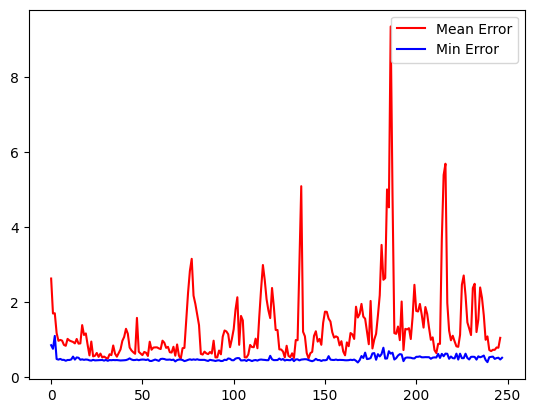

C:\Users\Bram\AppData\Local\Temp\ipykernel_24560\2057782547.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)


[[-0.3318276523608319, 0.05595961925367918, 0.09235815252165187, 0.16621485555634485, 0.35667000619050593], [0.2607160953209624, 0.32293304518358995, 0.0520517742932192, 0.023604687098079336, 0.493140381480649], [0.12587849969590736, 0.3196654480565063, 0.025876086577660874, 0.3370868429161499, 0.5043556278726985], [-0.2644471862556335, 0.23824112548274035, 0.08759603519249823, -0.2999132700854239, 0.0388632072209405], [-0.3774145650512473, 0.2833764951959226, 0.010141289184775372, -0.051257863766010825, 0.21825311047766657], [-0.3825596780691733, 0.1987114389149594, 0.011541001140856733, -0.0027752354508381316, 0.40259040703283644], [0.035150452673720356, 0.15216704780641707, 0.0764493611561161, -0.010795931371145151, 0.16157167562376795], [-0.3391264738050729, 0.12480317380484748, 0.087945331401521, -0.11641532996495702, 0.5385100066483468], [-0.3063867573990462, 0.17705713070350604, 0.0027784399711490606, -0.1285765032668918, 0.7419667532479339], [0.1843777478387556, 0.2585796873076

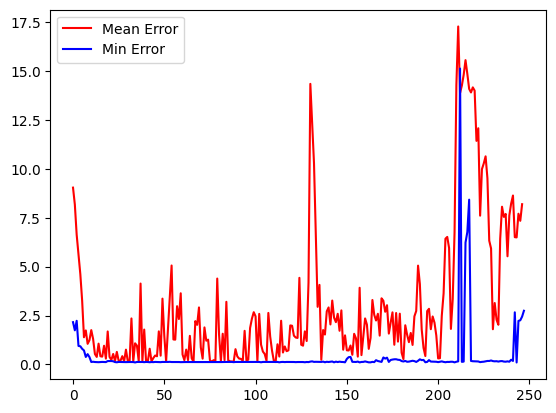

In [98]:
__TICKERS_TO_CHECK=["MSFT","^SPX","NVDA","AAPL","TSLA"]
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
for l in __TICKERS_TO_CHECK:
    M=GeneticAlgorithm(Merton(0.05,0.2,0.5,0.1,0.4),pd.read_csv(f"{l}_option_chain.csv"),np.array([[-np.inf,np.inf],[0.01, np.inf],[0.0001, np.inf],[-np.inf,np.inf],[0.01,np.inf]]),16,original_price=yf.Ticker(l).history(period="1d")["Close"][0],ticker=l)
    M.run(16)

In [37]:
class BSControl():
    def __init__(self,mu,sig):
        self.mu=mu
        self.sigma=sig
    def update_params(self,params):
        self.sigma=params[1]
        self.mu=params[0]
    def update_time(self,time):
        pass
    def simulate_end(self,n,T,s0):
        S=s0*np.ones(n)
        normal_sample=gen.generate_normal(n,1).flatten()
        
        return S*np.exp((self.mu-self.sigma**2/2)*T+np.sqrt(T)*self.sigma*normal_sample)
    def prior(self):
        return [np.random.uniform(-1,1),np.random.uniform(0,2)]


In [ ]:
P=GeneticAlgorithm(CGMY(2,12,12,-0.6,0.04,0.05),pd.read_csv("MSFT_option_chain.csv"),np.array([[0,np.inf],[1,np.inf],[1,np.inf],[-np.inf,1.9],[-np.inf,np.inf]]),10,original_price=yf.Ticker("MSFT").history(period="1d")["Close"][0])
opt=P.run(10)

alpha: 3.380371565414009


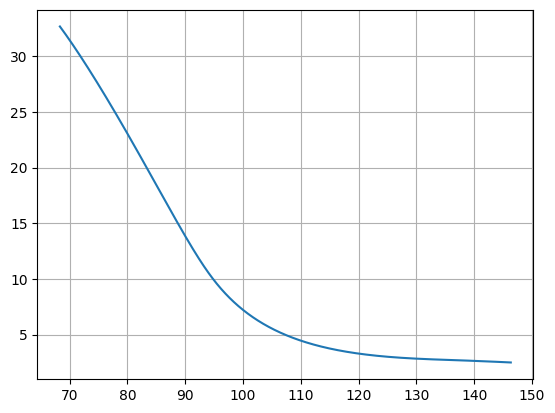

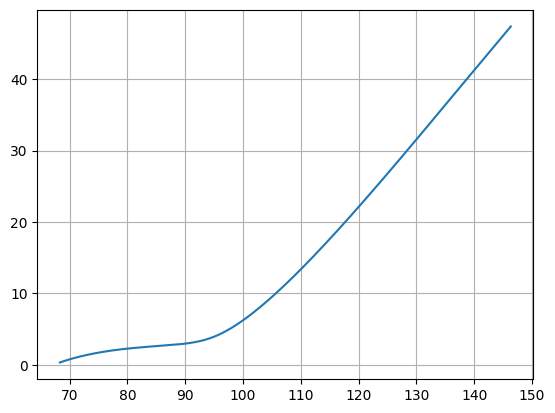

         Strike     Price
499   99.961889  6.201762
500  100.038125  6.245492


In [41]:
import numpy as np
import math
import scipy.stats as stats
import random_number_gen
from scipy.special import binom
import scipy
import pandas as pd
class AnalyticalPricing():
    def __init__(self,K,r,T,s0):
        self.K=K
        self.r=r
        self.T=T
        self.s0=s0
    def update_time(self,T):
        self.T=T

    def black_and_scholes(self,params=[]):
        if params !=[]:
            sigma=params[0]
            r=params[1]
        d1=(np.log(self.s0/self.K)+(r+0.5*sigma**2)*self.T)/(sigma*np.sqrt(self.T))
        d2=d1-sigma*np.sqrt(self.T)
        return self.s0*stats.norm.cdf(d1)-self.K*np.exp(-r*self.T)*stats.norm.cdf(d2)
    def MertonPrice(self,params=[],error=10e-9):
        if params !=[]:
            self.mu=params[0]
            self.sigma=params[1]
            self.l=params[2]
            self.muJ=params[3]
            self.sigJ=params[4]
        SUM=0
        term=1
        n=0
        while term>error:
            lambda_prime=self.l*(self.muJ)
            exp_term=np.exp(lambda_prime*self.T)*(lambda_prime*self.T)**n/math.factorial(n)
            v=np.sqrt(self.sigma**2+n*self.sigJ**2/self.T)
            rn=self.r-self.l*self.muJ+n*np.log(1+self.muJ)/self.T
            term=exp_term*self.black_and_scholes([v,rn])
            SUM+=term
            n+=1
        return SUM
    

    def HH_function(self,n,x): 
        if n<-1: return 0
        elif n==-1:
            return np.exp(-x**2/2)
        elif n==0:
            return math.sqrt(2*np.pi)*scipy.stats.norm.cdf(-x)
        else:
            return (self.HH_function(n-2,x)-x*self.HH_function(n-1,x))/n
        
            
    
    
    def I_function(self,c,alpha,beta,delta,n):
        
        if beta>0 and alpha!=0 and n>=-1:
            vect=0
            for o in range(0,n+1):
                hermit_comp=self.HH_function(o,beta*c-delta)
                pow_comp=(beta/alpha)**(n-o)
                vect+=hermit_comp*pow_comp
            
           
            
            summed=vect
            part1=-np.exp(alpha*c)/alpha*summed
            part2=(beta/alpha)**(n+1)*np.sqrt(2*np.pi)/beta*np.exp(alpha*delta/beta+alpha**2/(2*beta**2))*scipy.stats.norm.cdf(-beta*c+delta+alpha/beta)
            return part1+part2
        elif beta<0 and alpha<0 and n>=-1:
            vect=0
            for o in range(0,n+1):
                hermit_comp=self.HH_function(o,beta*c-delta)
                pow_comp=(beta/alpha)**(n-o)
                vect+=hermit_comp*pow_comp
            
            summed=vect
            part1=-np.exp(alpha*c)/alpha*summed
            part2=(beta/alpha)**(n+1)*np.sqrt(2*np.pi)/beta*np.exp(alpha*delta/beta+alpha**2/(2*beta**2))*scipy.stats.norm.cdf(beta*c-delta-alpha/beta)
            return part1-part2
        else:
            print(alpha,beta)
            print(n+1)
            raise ValueError("Invalid values for alpha and beta")

    
    def calculate_P_n(self,k,n,p,eta1,eta2):
        sum_term=0
        if k==n:
            return p**n
        for i in range(k,n):
            f1=binom(n-k-1,i-k)
            
            f2=binom(n,i)

            f3=(eta1/(eta1+eta2))**(i-k)
            f4=(eta2/(eta1+eta2))**(n-i)
           
            sum_term+=(f1*f2*f3*f4*p**i*(1-p)**(n-i))
        
        return sum_term
    def calculate_Q_n(self,k,n,p,eta1,eta2):
        sum_term=0
        if k==n:
            return (1-p)**n
        for i in range(k,n):
            f1=binom(n-k-1,i-k)
            f2=binom(n,i)
            f3=(eta1/(eta1+eta2))**(n-i)
            f4=(eta2/(eta1+eta2))**(i-k)
            sum_term+=(f1*f2*f3*f4)*(1-p)**i*(p)**(n-i)
        
        return sum_term
    def Upsilon_func(self,mu,sigma,lambda_,p,eta1,eta2,alpha,T,precision=10e-9):
        term1=np.exp((sigma*eta1)**2*T/2)/(sigma*np.sqrt(2*np.pi*T))
        error=precision/(2*term1) ##separate the error for each infinite sum
        
        n=1
        term2=10e15
        y=0
        while n<15:
           
            prob=np.exp(-lambda_*T)*(lambda_*T)**n/math.factorial(n)
            
            x=0
            for k in range(1,n+1):
                
                x+=self.calculate_P_n(k,n,p,eta1,eta2)*self.I_function(alpha-mu*T,-eta1,-1/(sigma*np.sqrt(T)),-sigma*eta1*np.sqrt(T),k-1)*(sigma*np.sqrt(T)*eta1)**k
                
            term2=prob*x
            y+=term2
            n+=1
            
       
        term3=np.exp((sigma*eta2)**2*T/2)/(sigma*np.sqrt(2*np.pi*T))
        error=precision/(2*term3)
        
        n=1
        term4=10e15
        z=0
        while n<15:
            prob=np.exp(-lambda_*T)*(lambda_*T)**n/math.factorial(n)
            x=0
            for k in range(1,n+1):
                x+=self.calculate_Q_n(k,n,p,eta1,eta2)*self.I_function(alpha-mu*T,eta2,1/(sigma*np.sqrt(T)),-sigma*eta2*np.sqrt(T),k-1)*(sigma*np.sqrt(T)*eta2)**k

            term4=prob*x
            z+=term4
            n+=1
        
        return term1*y+term3*z+np.exp(-lambda_*T)*scipy.stats.norm.cdf(-(alpha-mu*T)/(sigma*np.sqrt(T)))
    def KouPrice(self,params=[]):
        if params !=[]:
            mu=params[0]
            sigma=params[1]
            l=params[2]
            p=params[3]
            eta1=params[4]
            eta2=params[5]
        zeta=p*eta1/(eta1-1)+(1-p)*eta2/(1+eta2)-1
        lambda_=l*(1+zeta)
        eta2_wave=eta2+1
        eta1_wave=eta1-1
        p_wave=p/(1+zeta)*eta1/(eta1-1)
       
        return self.s0*self.Upsilon_func(mu+sigma**2/2-l*zeta,sigma,lambda_,p_wave,eta1_wave,eta2_wave,np.log(self.K/self.s0),self.T)- self.K*np.exp(-self.r*self.T)*self.Upsilon_func(mu-sigma**2/2-l*zeta,sigma,l,p,eta1,eta2,np.log(self.K/self.s0),self.T)
    def CGMY_Characteristic_Function(self,u,t,C,G,M,Y):
        return np.exp(t*(C*scipy.special.gamma(-Y)*((M-1j*u)**(Y)-M**Y+(G+1j*u)**(Y)-G**Y)))
    def Extended_CGMY_lnS_Char_Function(self,u,t,C,G,M,Y,eta,lnS,r):
        omega=-np.log(self.CGMY_Characteristic_Function(-1j,t,C,G,M,Y))/t
        part1=np.exp(1j*u*(lnS+(r+omega-eta**2/2)*t))
        part2=self.CGMY_Characteristic_Function(u,t,C,G,M,Y)*np.exp(-eta**2*u**2/2)
        #np.exp(t*C*scipy.special.gamma(-Y)*((G+1j*u)**Y-G**Y+(M-1j*u)**Y-M**Y-1j*u*Y-G**(Y-1)+1j*u*Y*M**(Y-1)))
        #self.CGMY_Characteristic_Function(u,t,C,G,M,Y)*np.exp(-eta**2*u**2/2)
       
        return part1*part2
        return 
    #part1*part2
    def Phi_Call_CGMY(self,v,j,t,C,G,M,Y,eta_CGMY,lnS,r,eta,alpha):
        return np.exp(-r*t)*self.Extended_CGMY_lnS_Char_Function(v-(alpha+1)*1j,t,C,G,M,Y,eta_CGMY,lnS,r)/(alpha**2+alpha-v**2+1j*(2*alpha+1)*v)
    def find_minimal_alpha_1(self,j,T,C,G,M,Y,eta_cgmy,lnS,r,eta,v_range):
        if Y<1:
            bounds=(0.01,20)
        else:
            bounds=(0.01,20)
        
        return scipy.optimize.minimize_scalar(lambda x: np.mean(np.array([np.real(self.Phi_Call_CGMY(v,j,self.T,C,G,M,Y,eta_cgmy,lnS,self.r,eta,x)) for v in v_range])**2),bounds=bounds,method="bounded").x
    def CGMYPrice(self,eta,params=[],N=1000):
        if params !=[]:
            C=params[0]
            G=params[1]
            M=params[2]
            Y=params[3]
            eta_cgmy=params[4]
        
        lnS=np.log(1)
        log_price_grid=np.linspace(-np.pi/eta+lnS,np.pi/eta+lnS,N)
        alpha=self.find_minimal_alpha_1(1,self.T,C,G,M,Y,eta_cgmy,lnS,self.r,eta,log_price_grid)*0.235
        print("alpha:",alpha)
       
        b=np.pi/eta+lnS
        strike_spacing=2*np.pi/(N*eta)
        
        strike_vector=[]
        for u in range(1,N+1):
            sum1=0
            
            for j in range(1,N+1):
                exp_factor=np.exp(-1j*(j-1)*eta*log_price_grid[u-1])
                
                function_call=self.Phi_Call_CGMY((j-1)*eta,j,self.T,C,G,M,Y,eta_cgmy,lnS,self.r,eta,alpha)
               
                Simpson_factor=eta/3*(3+(-1)**j-int(j==1)) #-(j==1)
                
                
                sum1+=exp_factor*function_call*Simpson_factor
            
            strike_vector.append(np.exp(-alpha*log_price_grid[u-1])*sum1/(np.pi))
        adjustment=(np.exp(self.r*self.T)-np.exp(log_price_grid[0]))/strike_vector[0]
        strike_vector=[i*adjustment for i in strike_vector]
        plt.plot(np.exp(log_price_grid)*100,100*np.real(strike_vector))
        plt.grid(visible=True)
        plt.show()
        return 100*np.exp(log_price_grid),np.real(strike_vector)*100
    def zeta_func(self,v,T,C,G,M,Y,lnS):
        return np.exp(-self.r*T)*(1/(1+1j*v)-np.exp(self.r*T)/(1j*v)-self.Extended_CGMY_lnS_Char_Function(v-1j,T,C,G,M,Y,0,lnS,self.r)/(v**2-1j*v))
    def gamma_func(self,v,T,C,G,M,Y,lnS,alpha):
       
        return (self.zeta_func(v-1j*alpha,T,C,G,M,Y,lnS)-self.zeta_func(v+1j*alpha,T,C,G,M,Y,lnS))/2
        
    def CGMYPrice2(self
                   ,eta,alpha,params=[],N=1012):
        if params !=[]:
            C=params[0]
            G=params[1]
            M=params[2]
            Y=params[3]
            eta_cgmy=params[4]
        
        lnS=np.log(1)
        log_price_grid=np.linspace(-np.pi/eta+lnS,np.pi/eta+lnS,N)
        
        b=np.pi/eta+lnS
        strike_spacing=2*np.pi/(N*eta)
        
        strike_vector=[]
        for u in range(1,N+1):
            sum1=0
            
            for j in range(1,N+1):
                exp_factor=np.exp(-1j*(j-1)*eta*log_price_grid[u-1])
                
                function_call=self.gamma_func((j-1)*eta,self.T,C,G,M,Y,lnS,alpha)
                
                Simpson_factor=eta/3*(3+(-1)**j-int(j==1)) #-(j==1)
                
                
                sum1+=exp_factor*function_call*Simpson_factor
            
            strike_vector.append(1/np.sinh(alpha*log_price_grid[u-1])*sum1/(np.pi))
       
        plt.plot(np.exp(log_price_grid)*100,np.abs(100*np.real(strike_vector)))
        plt.grid(visible=True)
        plt.show()
        return np.exp(log_price_grid)*100,np.abs(np.real(strike_vector))*100
X=AnalyticalPricing(100,0.04,0.25,100)
grid,prices=X.CGMYPrice(8.25,[0.5,3.5,2,0.5,0])


def calculate_put_values(strikes, call_prices, stock_price, interest_rate, time_to_expiration):
    
    strikes = np.array(strikes)
    call_prices = np.array(call_prices)
    
    #Calculate the put prices using the put-call parity formula
    put_prices = call_prices - stock_price + strikes * np.exp(-interest_rate * time_to_expiration)
    
    return put_prices
puts=calculate_put_values(grid,prices,100,0.04,0.25)
plt.plot(grid,puts)
plt.grid(True)
plt.show()
df=pd.DataFrame({"Strike":grid,"Price":puts})
print(df.loc[np.abs(df.Strike-100)<=0.05])





0.005050505050505051


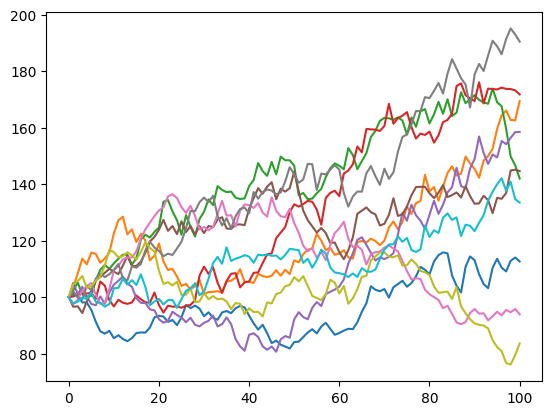

[100.          99.95888231 103.47880122 104.57757297 101.22507066
  98.73839034  95.38494123 101.82433079  99.004824   101.86927212
 102.27709274 103.69616203 108.4274708  108.29974448 111.42441215
 110.64208584 105.89315398 103.86776101 104.52217619 105.98078319
 105.89783215 105.07344507 100.03284582  99.44040125  99.5805336
 101.4184395   97.97492509  96.58323219  96.01224722  91.21751229
  91.15234704  93.39057701  92.82886274  95.79992661  94.90821943
  98.4151314   92.53651362  88.15213826  86.73428552  92.00391389
  94.82935739  89.94280744  90.58821984  93.38427917  97.76401606
 102.05718789 101.25504501  98.53776763 105.78414033 109.80970328
 110.6677255  109.50861383 112.29752053 113.53857015 112.49061772
 112.89739373 113.33752933 115.57374999 114.55745496 115.95033593
 116.47485963 113.41614823 108.56454806 112.07091223 115.69859794
 113.85950863 116.50785944 118.66751541 122.84893847 122.8352811
 123.14307224 123.67552438 123.32901973 123.67253715 121.85210863
 128.9950932

In [19]:
import scipy
import numpy as np
import scipy.special
import random_number_gen

import math
import matplotlib.pyplot as plt
from scipy.integrate import quadrature
class Subordinated_CGMY():
    def __init__(self,C,G,M,Y):
        self.C=C
        self.G=G
        self.M=M
        self.Y=Y
        
    def time_func(self,lambda_):
        return -1/lambda_*np.log(1-gen.Scrambled_Random())
    def Hermite_function(self,v,z):
        return scipy.integrate.quadrature(self.funct_to_integrate,0,1e6,args=(v,z))[0]
     
    def funct_to_integrate(self,x,v,z):
            
            return np.exp(-x**2/2-x*z)*np.power(x,(-v-1))/scipy.special.gamma(-v)
       
    

    
    def small_h(self,B,A,y):
        
        return np.exp(-(B**2-A**2)*y/2)*scipy.special.gamma(self.Y)/(scipy.special.gamma(self.Y/2)*2**(self.Y/2-1))*self.Hermite_function(-self.Y,B*np.sqrt(y))
        return np.exp(-B**2*y/2)*scipy.special.gamma(self.Y/2+1/2)/(scipy.special.gamma(self.Y)*scipy.special.gamma(1/2))*2**self.Y*(B**2*y/2)**(self.Y/2)*self.I_function(self.Y,B**2*y,B**2*y/2)

    def Big_H(self,t,L,epsilon,B,d,A):
        Gamm=self.time_func(L)
        
        y=epsilon/((1-gen.Scrambled_Random())**(2/self.Y))
        h_y=self.small_h(B,A,y)
       
        U=gen.Scrambled_Random()
        if Gamm>=t:
           
            return d*t

        else:
            Sig=d*t
            i=1
            while Gamm<t and i<10:
                if h_y>U:
                    #if y>1:
                        #print("Accepted")
                    #print("new_jump",y)
                    Sig+=y
                
                y=epsilon/((1-gen.Scrambled_Random())**(2/self.Y))
                #if y>1:
                    #print("jump",y)
                
                Gamm+=self.time_func(L)
                h_y=self.small_h(B,A,y)
                #if y>1:
                    #print("prob",h_y)
                U=gen.Scrambled_Random()
                i+=1
            return Sig

    def run(self,n,t,s0,r,epsilon=0.0001,returns=False):
        #self.C=scipy.special.gamma(self.Y/2)*scipy.special.gamma(1-self.Y/2)/scipy.special.gamma(1+self.Y/2)
        
        new_t=self.C
        #self.C
        A=(self.G-self.M)/2
        B=(self.G+self.M)/2
        d=epsilon**(1-self.Y/2)/(1-self.Y/2)
        L=2/self.Y*1/(epsilon**(self.Y/2))
        norm =gen.generate_normal(n,1).flatten()
        arr=s0*np.ones(n)
        
        for i in range(n):
            H=self.Big_H(new_t,L,epsilon,B,d,A)
            
            
            X=A*H+np.sqrt(H)*norm[i]
            
            if returns:
                
                arr[i]=X
            else:
                arr[i]*=np.exp(r*t+X)
       
        return arr
    def Monte_carlo(self,n,m,t,s0,r):
        newt=self.C
        dt=newt/(m-1)
        print(dt)
        arr=s0*np.ones((n,m+1))
        convexity_adjustment=-self.C*scipy.special.gamma(-self.Y)*((self.G+1)**self.Y-self.G**self.Y+(self.M-1)**self.Y-self.M**self.Y)
        #
        for j in range(1,m+1):
            run=self.run(n,dt,s0,r,returns=True)
            try:
                arr[:,j]=arr[:,j-1]*np.exp(t/m*(r-convexity_adjustment)+run)
            except RuntimeWarning as e:
                
                print(run)
        for l in arr[0:10]:
            plt.plot(l)
        plt.show()
        return arr
   
P=Subordinated_CGMY(0.5,3.5,2,0.5)
arr=P.Monte_carlo(1500,100,0.25,100,0.04)
# P2=CGMY(0.5,3.5,2,1.5,0,0.05)
# arr2=P2.simulate_end(1000,1,100)
print(arr[-1])
prices=arr[:,-1]
payoffs=np.maximum(100-arr[:,-1],0)
b_hat=np.cov(prices,payoffs)[0,1]/np.var(prices)
payoffs=payoffs-b_hat*(prices-np.exp(0.04*0.25)*100)
print(np.mean(payoffs))

print(payoffs)

In [1]:
P=Subordinated_CGMY(0.5,3.5,2,0.5)
arr=P.Monte_carlo(1500,100,0.25,100,0.04)
# P2=CGMY(0.5,3.5,2,1.5,0,0.05)
# arr2=P2.simulate_end(1000,1,100)
print(arr[-1])

payoffs=np.mean(np.maximum(100-arr[:,-1],0))*np.exp(-0.04/4)
print(payoffs)


NameError: name 'Subordinated_CGMY' is not defined

[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j,

c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[(-6.393914253326612+1.8607517171358092j), (-6.441631571299872+1.831377977612096j), (-6.489314725696163+1.801497274703636j), (-6.53695891617989+1.7711079436130577j), (-6.584559308104123+1.740208361254135j), (-6.63211103284182+1.7087969467659112j), (-6.679609188116261+1.6768721620217957j), (-6.727048838343931+1.644432512138607j), (-6.774425014982446+1.611476545983076j), (-6.821732716883739+1.5780028566748734j), (-6.868966910658443+1.544010082089521j), (-6.916122531042885+1.509496905357002j), (-6.963194481274398+1.4744620553579373j), (-7.010177633475072+1.4389043072185008j), (-7.057066829040269+1.402822482801237j), (-7.10385687903541+1.3662154511938842j), (-7.15054256459925+1.329082129195032j), (-7.197118637352142+1.2914214817959515j), (-7.243579819815917+1.253232522661735j), (-7.289920805834516+1.2145143146060124j), (-7.336136261007049+1.1752659700655366j), (-7.382220823122446+1.1354866515685842j), (-7.428169102605903+1.0951755722024232j), (-7.473975682968312+1.0543319960757498j), (-7.5

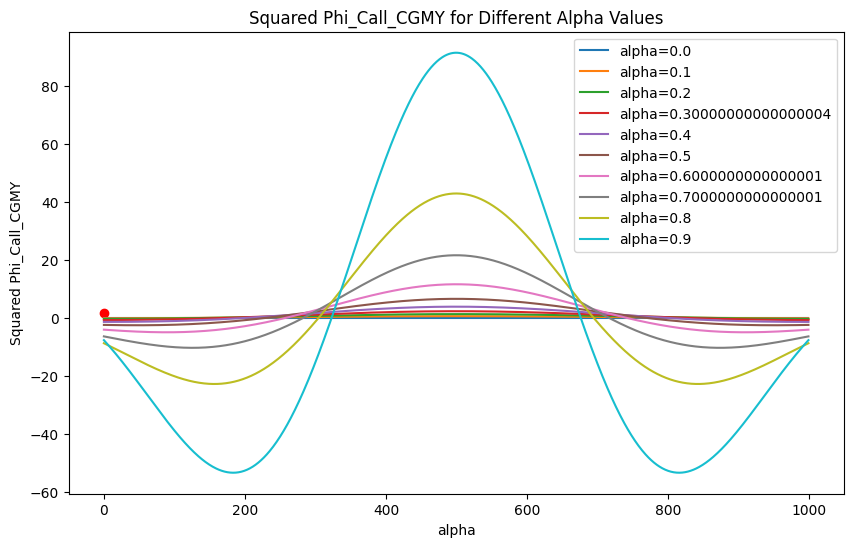

In [370]:
import numpy as np
import matplotlib.pyplot as plt

class CGMYModel: ##class meant to how the variability of functions used in the analytical pricing of CGMY model
    def CGMY_Characteristic_Function(self, u, t, C, G, M, Y):
        return np.exp(t * (C * scipy.special.gamma(-Y) * ((M - 1j * u) ** (Y) - M ** Y + (G + 1j * u) ** (Y) - G ** Y)))

    def Extended_CGMY_lnS_Char_Function(self, u, t, C, G, M, Y, eta, lnS, r):
        omega = -np.log(self.CGMY_Characteristic_Function(-1j, t, C, G, M, Y)) / t
        part1 = np.exp(1j * u * (lnS + (r + omega - eta ** 2 / 2) * t))
        part2 = self.CGMY_Characteristic_Function(u, t, C, G, M, Y) * np.exp(-eta ** 2 * u ** 2 / 2)
        return part1 * part2

    def Phi_Call_CGMY(self, v, j, t, C, G, M, Y, eta_CGMY, lnS, r, eta, alpha):
        return np.exp(-r * t) * self.Extended_CGMY_lnS_Char_Function(v - (alpha + 1) * 1j, t, C, G, M, Y, eta_CGMY, lnS, r) / (alpha ** 2 + alpha - v ** 2 + 1j * (2 * alpha + 1) * v)
    def zeta_func(self,v,T,C,G,M,Y,lnS):
        return np.exp(-0.05*T)*(1/(1+1j*v)-np.exp(0.05*T)/(1j*v)-self.Extended_CGMY_lnS_Char_Function(v-1j,T,C,G,M,Y,0,lnS,0.05)/(v**2-1j*v))
    def gamma_func(self,v,T,C,G,M,Y,lnS,alpha):
        #sinhc=lambda  x: np.sinh(x)/x if x!=0 else 1
        return (self.zeta_func(v-1j*alpha,T,C,G,M,Y,lnS)-self.zeta_func(v+1j*alpha,T,C,G,M,Y,lnS))/2

t = 1  
C = 1.0  
G = 5.0  
M = 5.0  
Y = 1.8  
eta_CGMY = 0  
lnS = 0.0  # Initial log-price
r = 0.1  # Risk-free rate
eta = 5.6  # Volatility parameter
j = 0  # Option type (0 for call, 1 for put)


v_range = np.linspace(-np.pi/eta, np.pi/eta, 1000)


alpha_values = np.linspace(0,0.9,10)


cgmy_model = CGMYModel()


plt.figure(figsize=(10, 6))
error_vals=[]
for alpha in alpha_values:
    phi_call_values = [cgmy_model.gamma_func(v,t,C,G,M,Y,lnS,alpha) for v in v_range]
    print(phi_call_values)
    plt.plot(phi_call_values,label=f"alpha={alpha}")
    error=np.real(np.mean(np.array(np.real(phi_call_values))**2))
    error_vals.append(error)

    
        
minimal=scipy.optimize.minimize_scalar(lambda x : np.mean(np.real([cgmy_model.gamma_func(v,t,C,G,M,Y,lnS,x) for v in v_range])**2),method="bounded",bounds=(0.3,1))
#plt.plot(alpha_values, error_vals)
plt.title('Squared Phi_Call_CGMY for Different Alpha Values')
plt.xlabel('alpha')
plt.ylabel('Squared Phi_Call_CGMY')
plt.scatter(minimal.x,minimal.fun,color="red")
print(minimal.x,minimal.fun)

plt.legend()
plt.show()

In [305]:
import scipy.optimize as optimize
T=CGMY(0.5,0.5,0.5,-1.8,0,0.05)
sims=T.simulate_paths(500,150,1,100,10e-10)

0.025
1.0023127173102648


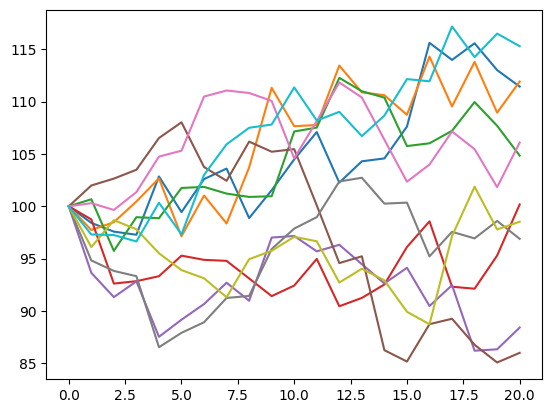

0.005
1.000462116161942
[113.02401175 126.96070692 107.18457665 ... 106.28583329 106.75965801
 117.87988682]
[113.02401175 126.96070692 110.         ... 110.         110.
 117.87988682]
16.72239168583866


In [443]:
X=Kou(0.05,0.2,3,0.3,1/0.02,1/0.04)
Y=X.simulate_paths(100,0.5,20,100)
for l in range(10):
    plt.plot(Y[l])

plt.show()
import numpy as np

def lookback_put_option_price(asset_paths, r, T,M=110,s0=100):

    num_paths = asset_paths.shape[0]
    discount_factor = np.exp(-r * T)
    print(np.amax(asset_paths, axis=1))
    max_values = np.maximum(np.amax(asset_paths, axis=1),M)
    print(max_values)
    payoffs=max_values
    #payoffs = np.maximum(max_values - asset_paths[:, -1], 0) - (max_values - min_values)
    
    option_price = discount_factor * np.mean(payoffs)-s0
    return option_price
print(lookback_put_option_price(X.simulate_paths(16000,1,200
,100),0.05,1))

In [95]:
Merton_model=Merton(0.05,0.1,3,-0.05,0.086)
L=80
U=120
K=100
r=0.05
Simulation=Merton_model.simulate_paths(100000,1,12,100)

def calculate_up_down_bounds_call(sims,r,t,up_K=None,down_K=None,s0=100,K=100):
    payoffs=[]
    if up_K is None or down_K is None:
        if up_K is not None:
            for i in sims:
                
                if np.any(i>=up_K):
                    
                    payoffs.append(0)
                else:
                     payoffs.append(np.maximum(i[-1]-K,0))
        elif down_K is not None:
            for i in sims:
                if np.any(i<=down_K):
                    payoffs.append(0)
                else:
                     payoffs.append(np.maximum(-(K-i[-1]),0))
        else:
            return 0

    else:
        for i in sims:
            
            if np.any(i>=up_K) or np.any(i<=down_K):
                
                payoffs.append(0)
            else:
                payoffs.append(np.maximum(i[-1]-K,0))
    
    return np.mean(payoffs)*np.exp(-r*t)
print(calculate_up_down_bounds_call(Simulation,0.05,1,up_K=120,K=100))

0.43522521615437887


In [61]:
Merton=CGMY(0.5,2,3.5,0.5,0,0.04)
def calculate_up_down_bounds_call(sims,r,t,up_K=None,down_K=None,s0=100,K=100):
    payoffs=[]
    if up_K is None or down_K is None:
        if up_K is not None:
            for i in sims:
                if np.any(i>=up_K):
                    payoffs.append(0)
                else:
                     payoffs.append(np.maximum(i[-1]-K,0))
        elif down_K is not None:
            for i in sims:
                if np.any(i<=down_K):
                    payoffs.append(0)
                else:
                     payoffs.append(np.maximum(i[-1]-K,0))
        else:
            return 0

    else:
        for i in sims:
            
            if np.any(i>=up_K) or np.any(i<=down_K):
                
                payoffs.append(0)
            else:
                payoffs.append(np.maximum(i[-1]-K,0))
            
    return np.mean(payoffs)*np.exp(-r*t)
sims=Merton.simulate_paths(10000,1,12,100,10e-15)

payoffff=calculate_up_down_bounds_call(sims,0.04,1,up_K=120,K=100)



additional_max_errror per point due to bounding 0.003623100478225589


AttributeError: 'CGMY' object has no attribute 'CumDensity'

In [97]:
from sklearn import linear_model
class Asian_option():


    def __init__(self, model,modelname,s0,K,params,CallPut,r,T,type_="Arithmetic"):
        self.model = model
        self.modelname=modelname
        self.pricer = AnalyticalPricing(K,r,T,s0)
        self.s0 = s0
        self.K = K
        self.CallPut = CallPut
        self.r = r
        self.T = T
        self.params=params
        self.type_=type_
    def calculate_control_prices(self,m,dt,T):
        
        

        
        self.pricer.update_time(T-(m*dt))
        if self.modelname=="Kou":
            price=self.pricer.KouPrice(self.params)
        elif self.modelname=="Merton":
            price=self.pricer.MertonPrice(self.params)
        control_prices=price
        return control_prices
    def calculate_option_price(self,n,m,control=True,lookback_period=3,controltype="option"):
        sims=self.model.simulate_paths(n,self.T,m)
        dt=self.T/(m)
        
        
        avg=np.zeros(n)
        for i in range(n):
            if self.CallPut=="Call":
                if not np.any(sims[i]>=120):
                    avg[i]=np.maximum(sims[i,-1]-self.K,0)
                else:
                    avg[i]=0
               
            else:
                if not np.any(sims[i]>=120):
                    avg[i]=np.maximum(self.K-sims[i,-1],0)
                else:
                    avg[i]=0
        for i in range(lookback_period):    
            if control:
                if self.CallPut=="Call":
                    sim_price=np.maximum(sims[:,-1]-self.K,0)
                else:
                    sim_price=np.maximum(self.K-sims[:,-1],0)
        
        
        if control:
            
            if controltype=="option":
                 b_hat=np.cov(sim_price,avg)[0,1]/np.var(sim_price)
                 control=sim_price
                 control_price=self.calculate_control_prices(0,dt,self.T)*np.exp(self.r*self.T)
            elif controltype=="stock":
                control=sims[:,-1]

                b_hat=np.cov(sims[:,-1],avg)[0,1]/np.var(sims[:,-1])
                control_price=self.s0*np.exp(self.r*self.T)
            # b_hat=np.cov(sim_prices.transpose(),avg.transpose())[0,1]/np.var(sim_prices)
            # print(b_hat)
           
            
            price = np.mean(avg - b_hat * (control - control_price)) * np.exp(-self.r * self.T)
            print(price)
            #print(np.mean(avg-RegStock.coef_*(sims-np.exp(dt*np.arange(1,m))*self.s0)))
        else:
            price=np.mean(avg)*np.exp(-self.r*self.T)
            print(price)
        return price
test=Asian_option(Merton(0.03,0.1,3,-0.05,0.086),"Merton",100,100,[0.05,0.1,3,-0.05,0.086],"Call",0.05,1,type_="Geometric")
test.calculate_option_price(int(1e4),12,control=False,controltype="option")

2.673793848581261


2.673793848581261